# Risk Models Using Tree-based Models



In this milestone, you'll gain experience with tree based models by predicting the 10-year risk of death of individuals from the NHANES I epidemiology dataset (for a detailed description of this dataset you can check the [CDC Website](https://wwwn.cdc.gov/nchs/nhanes/nhefs/default.aspx/)).


Studi kasus pada "10-year risk of death" menggunakan dataset epidemiologi dari NHANES (National Health and Nutrition Examination Survey) biasanya melibatkan analisis untuk memprediksi risiko kematian dalam 10 tahun ke depan bagi individu berdasarkan berbagai faktor kesehatan, gaya hidup, dan demografis. Studi ini banyak digunakan dalam epidemiologi untuk memahami faktor risiko yang berkontribusi terhadap kematian dini dan untuk membantu pengembangan program pencegahan kesehatan.

<a name='1'></a>
## 1. Import Packages

We'll first import all the common packages that we need for this assignment.

- `shap` is a library that explains predictions made by machine learning models.
- `sklearn` is one of the most popular machine learning libraries.
- `itertools` allows us to conveniently manipulate iterable objects such as lists.
- `pydotplus` is used together with `IPython.display.Image` to visualize graph structures such as decision trees.
- `numpy` is a fundamental package for scientific computing in Python.
- `pandas` is what we'll use to manipulate our data.
- `seaborn` is a plotting library which has some convenient functions for visualizing missing data.
- `matplotlib` is a plotting library.

In [111]:
pip install lifelines

In [112]:
import shap
import sklearn
import itertools
import pydotplus
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import Image
from sklearn.tree import export_graphviz
from six import StringIO
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import pickle
from google.colab import drive
from sklearn.feature_selection import SelectKBest, chi2, f_classif
import scipy.stats as stats
from lifelines.utils import concordance_index
from sklearn.impute import KNNImputer

In [113]:
# !pip install six

In [114]:
pip show scikit-learn


Name: scikit-learn
Version: 1.5.1
Summary: A set of python modules for machine learning and data mining
Home-page: https://scikit-learn.org
Author: 
Author-email: 
License: new BSD
Location: /usr/local/lib/python3.10/dist-packages
Requires: joblib, numpy, scipy, threadpoolctl
Required-by: bigframes, fastai, imbalanced-learn, librosa, mlxtend, sentence-transformers, shap, sklearn-pandas, yellowbrick


<a name='2'></a>
## 2. Load the Dataset

Run the next cell to load in the NHANES I epidemiology dataset. This dataset contains various features of hospital patients as well as their outcomes, i.e. whether or not they died within 10 years.

In [115]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [116]:
pathx = "/content/drive/MyDrive/AI Internship/Risk score death/NHANESI_subset_X.csv"
pathy = "/content/drive/MyDrive/AI Internship/Risk score death/NHANESI_subset_y.csv"

In [117]:
df_x = pd.read_csv(pathx)
df_y = pd.read_csv(pathy)

In [118]:
df_x.head()

,Unnamed: 0,Age,Diastolic BP,Poverty index,Race,Red blood cells,Sedimentation rate,Serum Albumin,Serum Cholesterol,Serum Iron,Serum Magnesium,Serum Protein,Sex,Systolic BP,TIBC,TS,White blood cells,BMI,Pulse pressure
0,0,35.0,92.0,126.0,2.0,77.7,12.0,5.0,165.0,135.0,1.37,7.6,2.0,142.0,323.0,41.8,5.8,31.109434,50.0
1,1,71.0,78.0,210.0,2.0,77.7,37.0,4.0,298.0,89.0,1.38,6.4,2.0,156.0,331.0,26.9,5.3,32.362572,78.0
2,2,74.0,86.0,999.0,2.0,77.7,31.0,3.8,222.0,115.0,1.37,7.4,2.0,170.0,299.0,38.5,8.1,25.388497,84.0
3,3,64.0,92.0,385.0,1.0,77.7,30.0,4.3,265.0,94.0,1.97,7.3,2.0,172.0,349.0,26.9,6.7,26.446610,80.0
4,4,32.0,70.0,183.0,2.0,77.7,18.0,5.0,203.0,192.0,1.35,7.3,1.0,128.0,386.0,49.7,8.1,20.354684,58.0


In [119]:

df_x = df_x.drop(df_x.columns[0], axis=1)

In [120]:
df_x

,Age,Diastolic BP,Poverty index,Race,Red blood cells,Sedimentation rate,Serum Albumin,Serum Cholesterol,Serum Iron,Serum Magnesium,Serum Protein,Sex,Systolic BP,TIBC,TS,White blood cells,BMI,Pulse pressure
0,35.0,92.0,126.0,2.0,77.7,12.0,5.0,165.0,135.0,1.37,7.6,2.0,142.0,323.0,41.8,5.8,31.109434,50.0
1,71.0,78.0,210.0,2.0,77.7,37.0,4.0,298.0,89.0,1.38,6.4,2.0,156.0,331.0,26.9,5.3,32.362572,78.0
2,74.0,86.0,999.0,2.0,77.7,31.0,3.8,222.0,115.0,1.37,7.4,2.0,170.0,299.0,38.5,8.1,25.388497,84.0
3,64.0,92.0,385.0,1.0,77.7,30.0,4.3,265.0,94.0,1.97,7.3,2.0,172.0,349.0,26.9,6.7,26.446610,80.0
4,32.0,70.0,183.0,2.0,77.7,18.0,5.0,203.0,192.0,1.35,7.3,1.0,128.0,386.0,49.7,8.1,20.354684,58.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9927,26.0,76.0,491.0,1.0,46.6,9.0,4.7,137.0,90.0,1.39,7.4,1.0,104.0,316.0,28.5,10.7,21.468805,28.0
9928,69.0,82.0,316.0,1.0,48.0,18.0,4.7,301.0,98.0,2.02,6.7,2.0,130.0,334.0,29.3,7.1,23.090226,48.0
9929,34.0,80.0,187.0,1.0,47.3,10.0,4.5,161.0,95.0,1.54,6.9,2.0,110.0,381.0,24.9,5.4,25.797680,30.0
9930,57.0,84.0,999.0,1.0,54.7,5.0,4.5,210.0,93.0,1.82,7.0,1.0,130.0,337.0,27.6,6.2,23.406200,46.0


In [121]:
df_y = df_y.drop(df_y.columns[0], axis=1)

In [122]:
df_y.head()

,y
0,15.274658
1,11.586073
2,8.149087
3,-21.094292
4,-0.000000



## 3. Explore the Dataset



Berikut adalah penjelasan singkat untuk masing-masing kolom dalam DataFrame tersebut:

1. **Age**: Usia subjek (dalam tahun).
2. **Diastolic BP**: Tekanan darah diastolik (tekanan dalam pembuluh darah saat jantung beristirahat antara detak, diukur dalam mmHg).
3. **Poverty index**: Indeks kemiskinan subjek, yang mungkin menunjukkan kondisi ekonomi.
4. **Race**: Variabel numerik yang menunjukkan kategori ras subjek.

 Sumber : https://wwwn.cdc.gov/nchs/data/nhefs/1992mort.pdf (Hal 26)

 Range nilai Race
- 1 = white
- 2 = Races other
- 3 = Black

5. **Red blood cells**: Jumlah sel darah merah (sebagai konsentrasi atau hitungan sel darah merah per volume darah).
6. **Sedimentation rate**: Laju endap darah, digunakan untuk mengukur tingkat inflamasi dalam tubuh.
7. **Serum Albumin**: Kadar albumin serum, protein penting dalam darah, yang menunjukkan fungsi hati atau status gizi.
8. **Serum Cholesterol**: Kadar kolesterol dalam serum darah.
9. **Serum Iron**: Kadar zat besi dalam serum darah.
10. **Serum Magnesium**: Kadar magnesium dalam serum darah.
11. **Serum Protein**: Jumlah total protein dalam serum darah, termasuk albumin dan globulin.
12. **Sex**: Jenis kelamin subjek (dalam format numerik).

 Variabel Sex Sumber : https://wwwn.cdc.gov/nchs/data/nhefs/1992mort.pdf (Hal 25)

- 1 = Male
- 2 = Female
13. **Systolic BP**: Tekanan darah sistolik (tekanan dalam pembuluh darah saat jantung memompa darah).
14. **TIBC (Total Iron Binding Capacity)**: Kapasitas total darah untuk mengikat zat besi, menunjukkan kemampuan darah dalam mengangkut zat besi.
15. **TS (Transferrin Saturation)**: Persentase saturasi transferrin, menunjukkan seberapa banyak zat besi yang terikat dengan protein transferrin.
16. **White blood cells**: Jumlah sel darah putih, digunakan untuk mengukur kesehatan sistem kekebalan tubuh.
17. **BMI (Body Mass Index)**: Indeks massa tubuh, mengukur hubungan antara berat badan dan tinggi badan.
18. **Pulse pressure**: Perbedaan antara tekanan darah sistolik dan diastolik, digunakan sebagai indikator kesehatan kardiovaskular.


In [123]:


df_combined = pd.concat([df_x, df_y], axis=1)

In [124]:
df_x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9932 entries, 0 to 9931
Data columns (total 18 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Age                 9932 non-null   float64
 1   Diastolic BP        9874 non-null   float64
 2   Poverty index       9932 non-null   float64
 3   Race                9932 non-null   float64
 4   Red blood cells     9932 non-null   float64
 5   Sedimentation rate  9106 non-null   float64
 6   Serum Albumin       9932 non-null   float64
 7   Serum Cholesterol   9932 non-null   float64
 8   Serum Iron          9932 non-null   float64
 9   Serum Magnesium     9932 non-null   float64
 10  Serum Protein       9932 non-null   float64
 11  Sex                 9932 non-null   float64
 12  Systolic BP         9875 non-null   float64
 13  TIBC                9932 non-null   float64
 14  TS                  9932 non-null   float64
 15  White blood cells   8891 non-null   float64
 16  BMI   

In [125]:
df_y.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9932 entries, 0 to 9931
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   y       9932 non-null   float64
dtypes: float64(1)
memory usage: 77.7 KB


In [126]:
df_combined.describe()

,Age,Diastolic BP,Poverty index,Race,Red blood cells,Sedimentation rate,Serum Albumin,Serum Cholesterol,Serum Iron,Serum Magnesium,Serum Protein,Sex,Systolic BP,TIBC,TS,White blood cells,BMI,Pulse pressure,y
count,9932.000000,9874.000000,9932.000000,9932.000000,9932.000000,9106.000000,9932.000000,9932.000000,9932.000000,9932.000000,9932.000000,9932.000000,9875.000000,9932.000000,9932.000000,8891.000000,9932.000000,9873.000000,9932.000000
mean,49.449054,83.281953,287.213049,1.196033,54.880528,16.268285,4.365103,221.234837,101.117298,1.681307,7.104068,1.607229,134.854481,362.604511,28.555910,7.451760,25.689771,51.575509,-8.138465
std,15.878425,13.291925,223.310410,0.423045,14.600767,11.511728,0.331212,49.494473,37.211666,0.145905,0.508969,0.488391,24.932032,58.993649,11.232671,2.292071,5.184155,18.299075,14.848999
min,25.000000,25.000000,2.000000,1.000000,21.400000,1.000000,2.700000,53.000000,17.000000,0.820000,4.400000,1.000000,80.000000,112.000000,3.200000,2.100000,12.585333,10.000000,-22.058676
25%,35.000000,74.000000,130.000000,1.000000,45.000000,7.000000,4.200000,187.000000,75.000000,1.590000,6.800000,1.000000,118.000000,322.000000,21.000000,6.000000,22.108338,40.000000,-20.103653
50%,48.000000,82.000000,233.000000,1.000000,48.900000,14.000000,4.400000,217.000000,96.000000,1.680000,7.100000,2.000000,130.000000,356.000000,27.200000,7.200000,24.928952,48.000000,-18.710502
75%,66.000000,90.000000,372.000000,1.000000,57.600000,22.000000,4.600000,250.000000,122.000000,1.770000,7.400000,2.000000,150.000000,396.000000,34.600000,8.600000,28.369043,60.000000,7.006450
max,74.000000,180.000000,999.000000,3.000000,88.800000,72.000000,5.700000,793.000000,396.000000,2.890000,11.500000,2.000000,270.000000,717.000000,100.000000,56.000000,72.218113,170.000000,21.471461


Pada data x Terdapat beberapa kolom yang meiliki missing value , dan data y nilai nya harus di analis apakah itu hasil risk scorenya atau Residuals atau Errors.

disini kita akan menganalisis variabel y terlebih dahulu , lalu menangani missing value.

### Analisis variabel y

 - Pada fitur x belum di-log atau ditransformasikan, maka kemungkinan besar variabel y juga bukan hasil  di-log atau di-transform.

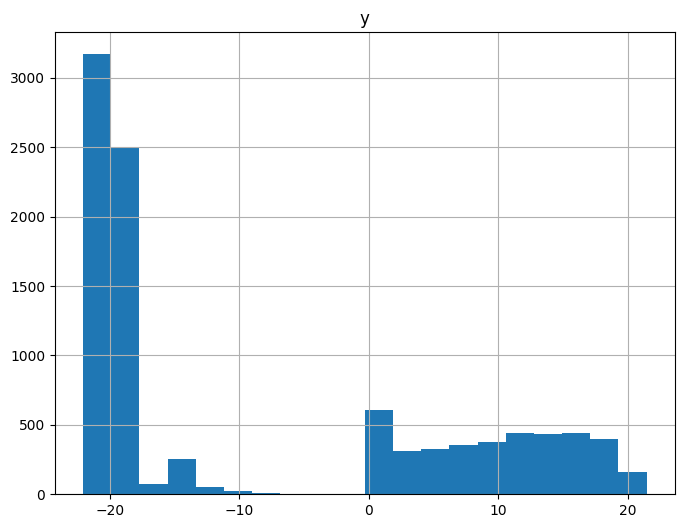

In [127]:
df_y.hist(bins=20, figsize=(8, 6))
plt.show()

Pada histogram di atas terlihat ada dua kluster:
- Satu kluster di nilai negatif besar (sekitar -20), dan
- Satu kluster di nilai positif (0 hingga 20).

Ini bisa jadi menggambarkan dua kategori pasien:
- Negatif besar → pasien dengan risiko rendah atau tidak berisiko.
- Positif → pasien dengan risiko lebih tinggi atau lebih mungkin mengalami outcome (kematian dalam 10 tahun).

Pola ini sangat umum dalam model prediksi risiko yang mengklasifikasikan pasien menjadi berisiko rendah dan tinggi.

Berdasarkan penjelasan di atas, sepertinya y adalah semacam skor risiko atau metrik hasil prediksi yang menunjukkan seberapa besar kemungkinan seorang pasien meninggal dalam 10 tahun.

Cek koefisien sebelum target y jadi biner

In [128]:
# Menghitung matriks korelasi dengan mengecualikan kolom Cholesterol_Category
correlation_matrix = df_combined.corr()

# Menampilkan matriks korelasi
print(correlation_matrix)

                         Age  Diastolic BP  Poverty index      Race  \
Age                 1.000000      0.260866      -0.030336 -0.003557   
Diastolic BP        0.260866      1.000000      -0.060916  0.140706   
Poverty index      -0.030336     -0.060916       1.000000 -0.162852   
Race               -0.003557      0.140706      -0.162852  1.000000   
Red blood cells     0.030538      0.053564       0.023129 -0.021594   
Sedimentation rate  0.206879      0.052781      -0.133960  0.178287   
Serum Albumin      -0.202611      0.012841       0.078224 -0.096122   
Serum Cholesterol   0.346071      0.166768       0.021656 -0.016785   
Serum Iron         -0.016897     -0.043386       0.088710 -0.076524   
Serum Magnesium     0.083664      0.018601       0.041488 -0.148282   
Serum Protein      -0.036282      0.146220      -0.090320  0.223579   
Sex                -0.159728     -0.139100      -0.066834  0.011563   
Systolic BP         0.508256      0.699314      -0.091837  0.119699   
TIBC  

In [129]:
# Binarisasi score risk, score 0 dianggap tidak berisiko, langsung diubah pada kolom 'y'
df_combined['y'] = df_combined['y'].apply(lambda x: 1 if x > 0 else 0)

# Menampilkan hasil
print(df_combined[['y']])


      y
0     1
1     1
2     1
3     0
4     0
...  ..
9927  1
9928  0
9929  0
9930  0
9931  1

[9932 rows x 1 columns]


In [130]:
df_combined

,Age,Diastolic BP,Poverty index,Race,Red blood cells,Sedimentation rate,Serum Albumin,Serum Cholesterol,Serum Iron,Serum Magnesium,Serum Protein,Sex,Systolic BP,TIBC,TS,White blood cells,BMI,Pulse pressure,y
0,35.0,92.0,126.0,2.0,77.7,12.0,5.0,165.0,135.0,1.37,7.6,2.0,142.0,323.0,41.8,5.8,31.109434,50.0,1
1,71.0,78.0,210.0,2.0,77.7,37.0,4.0,298.0,89.0,1.38,6.4,2.0,156.0,331.0,26.9,5.3,32.362572,78.0,1
2,74.0,86.0,999.0,2.0,77.7,31.0,3.8,222.0,115.0,1.37,7.4,2.0,170.0,299.0,38.5,8.1,25.388497,84.0,1
3,64.0,92.0,385.0,1.0,77.7,30.0,4.3,265.0,94.0,1.97,7.3,2.0,172.0,349.0,26.9,6.7,26.446610,80.0,0
4,32.0,70.0,183.0,2.0,77.7,18.0,5.0,203.0,192.0,1.35,7.3,1.0,128.0,386.0,49.7,8.1,20.354684,58.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9927,26.0,76.0,491.0,1.0,46.6,9.0,4.7,137.0,90.0,1.39,7.4,1.0,104.0,316.0,28.5,10.7,21.468805,28.0,1
9928,69.0,82.0,316.0,1.0,48.0,18.0,4.7,301.0,98.0,2.02,6.7,2.0,130.0,334.0,29.3,7.1,23.090226,48.0,0
9929,34.0,80.0,187.0,1.0,47.3,10.0,4.5,161.0,95.0,1.54,6.9,2.0,110.0,381.0,24.9,5.4,25.797680,30.0,0
9930,57.0,84.0,999.0,1.0,54.7,5.0,4.5,210.0,93.0,1.82,7.0,1.0,130.0,337.0,27.6,6.2,23.406200,46.0,0


Cek Coefisien Setelah jadi binner

In [131]:
# Menghitung matriks korelasi dengan mengecualikan kolom Cholesterol_Category
correlation_matrix1 = df_combined.corr()

# Menampilkan matriks korelasi
print(correlation_matrix1)

                         Age  Diastolic BP  Poverty index      Race  \
Age                 1.000000      0.260866      -0.030336 -0.003557   
Diastolic BP        0.260866      1.000000      -0.060916  0.140706   
Poverty index      -0.030336     -0.060916       1.000000 -0.162852   
Race               -0.003557      0.140706      -0.162852  1.000000   
Red blood cells     0.030538      0.053564       0.023129 -0.021594   
Sedimentation rate  0.206879      0.052781      -0.133960  0.178287   
Serum Albumin      -0.202611      0.012841       0.078224 -0.096122   
Serum Cholesterol   0.346071      0.166768       0.021656 -0.016785   
Serum Iron         -0.016897     -0.043386       0.088710 -0.076524   
Serum Magnesium     0.083664      0.018601       0.041488 -0.148282   
Serum Protein      -0.036282      0.146220      -0.090320  0.223579   
Sex                -0.159728     -0.139100      -0.066834  0.011563   
Systolic BP         0.508256      0.699314      -0.091837  0.119699   
TIBC  

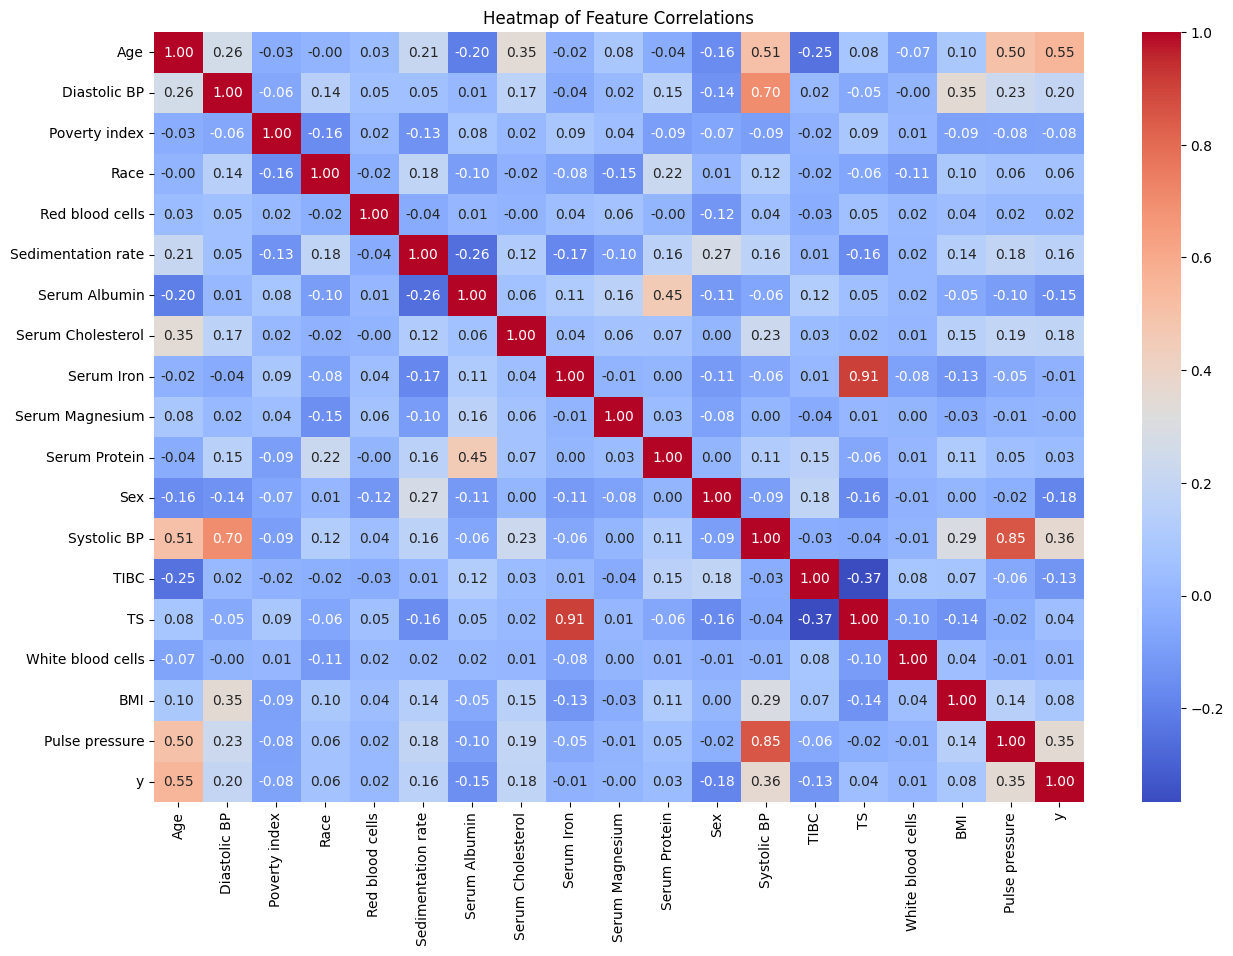

In [132]:
# Membuat heatmap
plt.figure(figsize=(15,10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Heatmap of Feature Correlations')
plt.show()

Dari Hasil  Pemilihan Variabel
Variabel dengan Korelasi Paling Tinggi dengan y:

- Age: 0.55 → Korelasi kuat dan positif.
- Pulse pressure: 0.391940 → Korelasi sedang.
- Systolic BP: 0.36 → Korelasi sedang.

Variabel dengan Korelasi Sedang ke Rendah:

- Diastolic BP: 0.20
- Serum Cholesterol: 0.18
- Sedimentation rate: 0.16

Variabel dengan Korelasi Lemah atau Tidak Signifikan:

- Variabel seperti Red blood cells (0.026968) atau White blood cells (0.015416) menunjukkan korelasi yang sangat lemah dan mungkin tidak relevan dalam model.

Variabel dengan Korelasi Negatif Signifikan:
- Serum Albumin (-0.15)


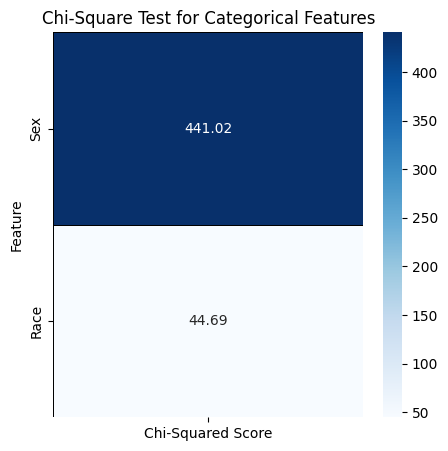

In [133]:
# Uji Chi-Square untuk setiap fitur kategorik terhadap target
results = []
for col in ['Race', 'Sex']:
    contingency_table = pd.crosstab(df_combined[col], df_combined['y'])
    chi2, p, dof, expected = stats.chi2_contingency(contingency_table)
    results.append({'Feature': col, 'Chi-Squared Score': chi2, 'P-Value': p})

# Buat DataFrame hasil uji Chi-Square
feature_scores = pd.DataFrame(results).set_index('Feature')

# Visualisasi dengan heatmap
plt.figure(figsize=(5, 5))
sns.heatmap(feature_scores[['Chi-Squared Score']].sort_values(by='Chi-Squared Score', ascending=False),
            annot=True, cmap='Blues', linewidths=0.4, linecolor='black', fmt='.2f')
plt.title('Chi-Square Test for Categorical Features')
plt.show()

Variabe Sex Miliki nilai Chi square yang tinggi

Berdasarkan analisis ini, Anda dapat memilih variabel berikut untuk membangun model prediksi:

- Age
- Pulse pressure
- Systolic BP
- Diastolic BP
- Serum Cholesterol
- Sedimentation rate
- Sex
- Serum Albumin


In [134]:
df = df_combined[["Age","Pulse pressure","Systolic BP","Diastolic BP","Serum Cholesterol","Sedimentation rate","Sex","Serum Albumin","y"]]

### Analisis Variabel x

Melihat Distribusi dari masing masing feature dan Outliernya

               Age  Pulse pressure  Systolic BP  Diastolic BP  \
count  9932.000000     9873.000000  9875.000000   9874.000000   
mean     49.449054       51.575509   134.854481     83.281953   
std      15.878425       18.299075    24.932032     13.291925   
min      25.000000       10.000000    80.000000     25.000000   
25%      35.000000       40.000000   118.000000     74.000000   
50%      48.000000       48.000000   130.000000     82.000000   
75%      66.000000       60.000000   150.000000     90.000000   
max      74.000000      170.000000   270.000000    180.000000   

       Serum Cholesterol  Sedimentation rate          Sex  Serum Albumin  \
count        9932.000000         9106.000000  9932.000000    9932.000000   
mean          221.234837           16.268285     1.607229       4.365103   
std            49.494473           11.511728     0.488391       0.331212   
min            53.000000            1.000000     1.000000       2.700000   
25%           187.000000          

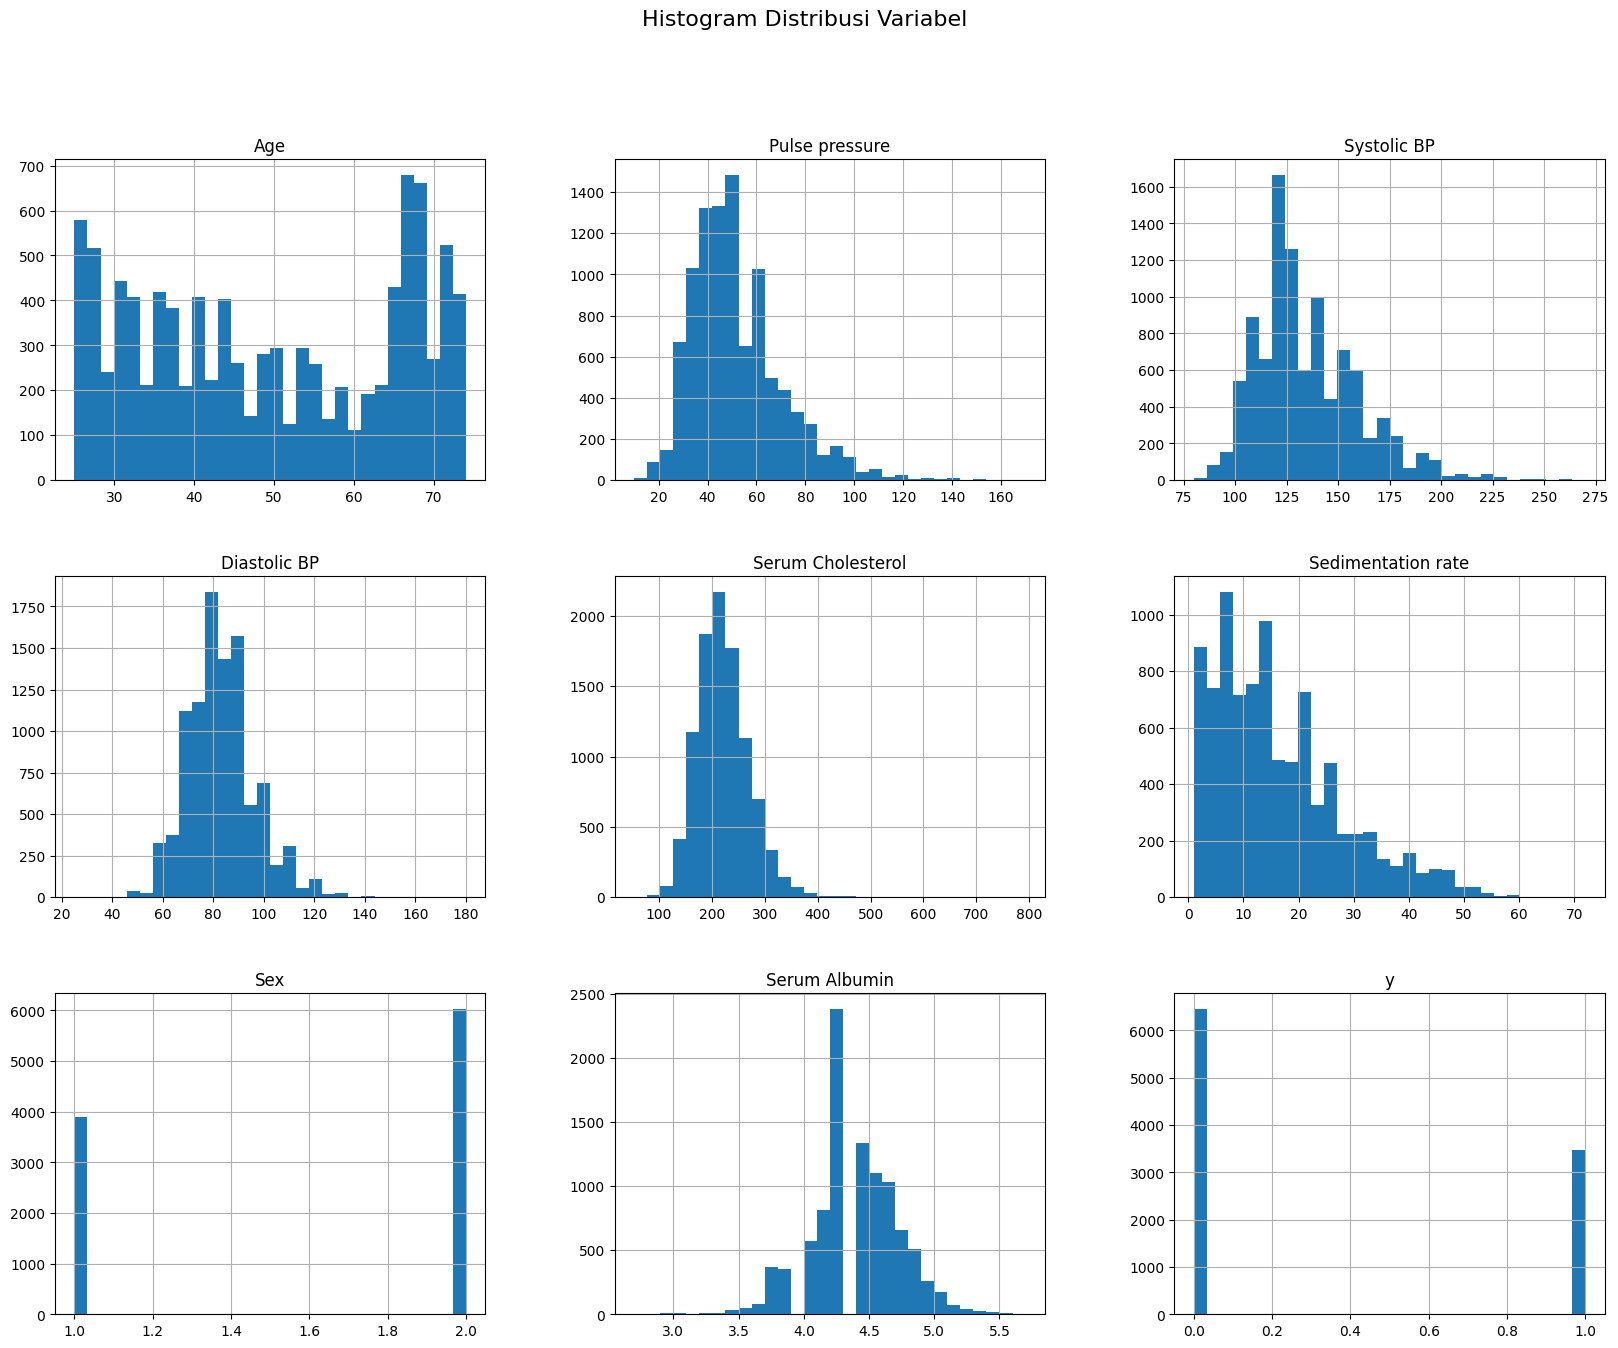

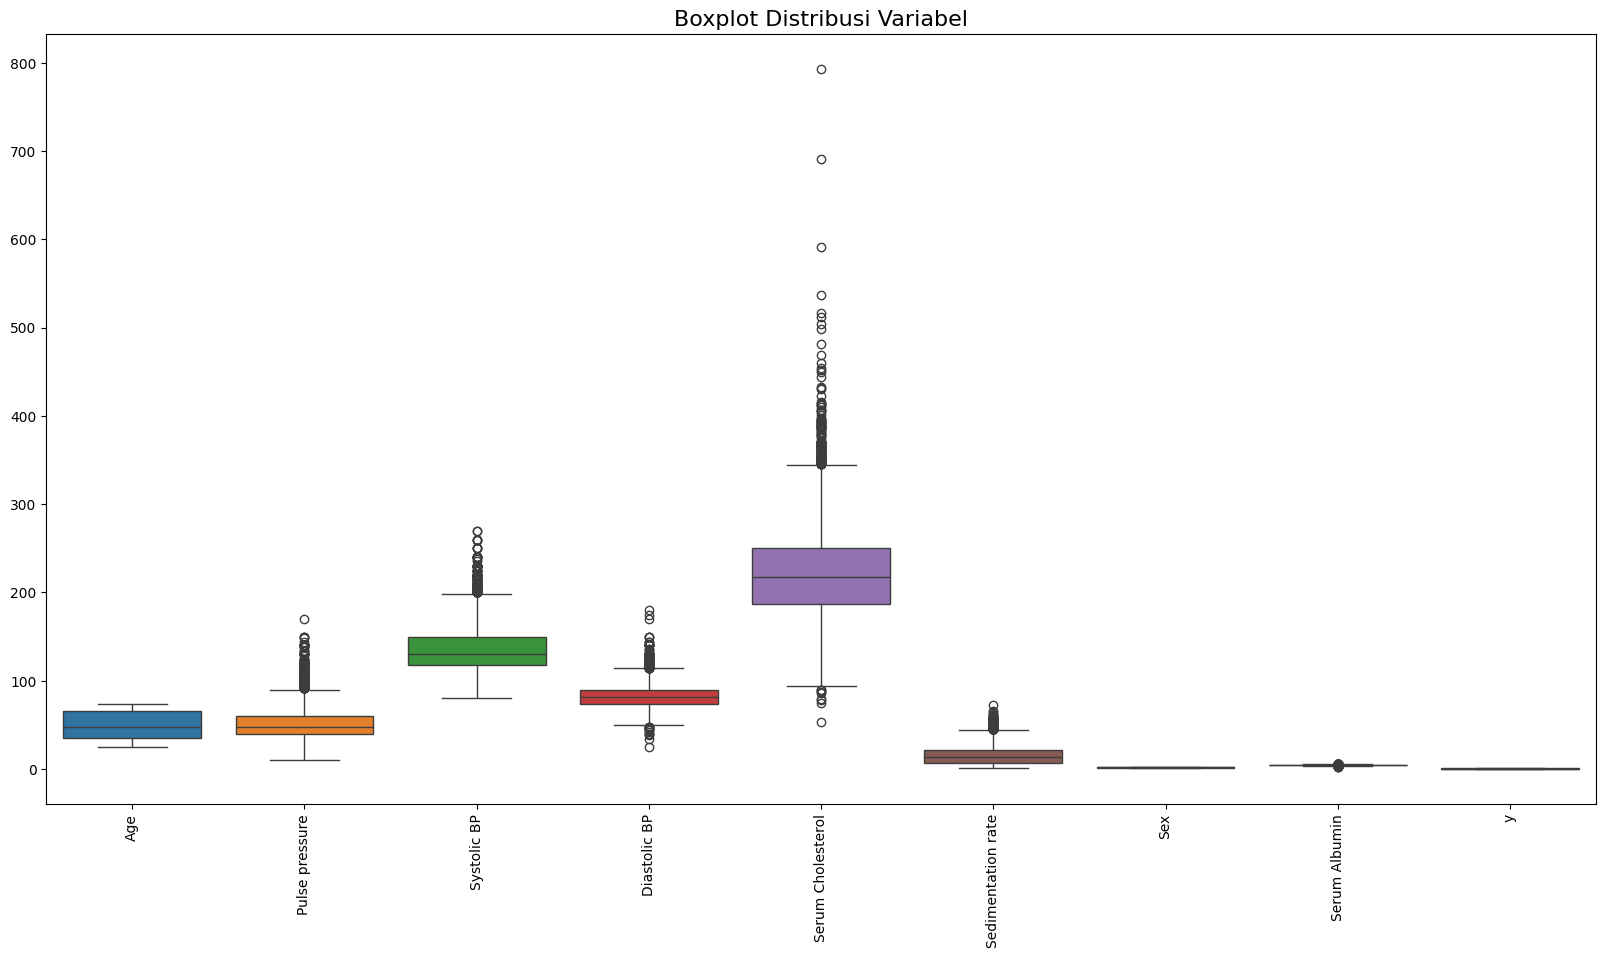

In [135]:
# Melihat statistik deskriptif untuk setiap variabel di df
print(df.describe())

# Menampilkan histogram untuk setiap variabel di df
df.hist(bins=30, figsize=(20, 15))
plt.suptitle('Histogram Distribusi Variabel', fontsize=16)
plt.show()

# Menampilkan boxplot untuk setiap variabel di df
plt.figure(figsize=(20, 10))
sns.boxplot(data=df)
plt.title('Boxplot Distribusi Variabel', fontsize=16)
plt.xticks(rotation=90)
plt.show()

Dari Hasil ada kolom yang bertype category yaitu : Race dan Sex

In [136]:
def checkUniq(col):
    """Mengembalikan nilai unik dari kolom yang ditentukan dalam DataFrame."""
    res = df[col].unique()
    return res

def cari_min_max(col):
    """Mengembalikan nilai minimum dan maksimum dari kolom yang ditentukan dalam DataFrame."""
    min_val = df[col].min()
    max_val = df[col].max()
    return min_val, max_val

columns = df

for column in columns:
    print(f"Unique values in {column}:")
    print(checkUniq(column))

    # Cari nilai minimum dan maksimum untuk kolom numerik
    try:
        min_val, max_val = cari_min_max(column)
        print(f"Minimum value in {column}: {min_val}")
        print(f"Maximum value in {column}: {max_val}")
    except TypeError:
        print(f"Cannot calculate min/max for non-numeric column: {column}")

    print("\n" + "-"*40 + "\n")


Unique values in Age:
[35. 71. 74. 64. 32. 40. 53. 36. 49. 31. 51. 34. 28. 42. 41. 68. 27. 65.
 38. 37. 46. 44. 30. 56. 55. 43. 70. 47. 60. 73. 69. 72. 67. 66. 26. 25.
 62. 33. 54. 50. 48. 29. 57. 58. 45. 59. 61. 52. 39. 63.]
Minimum value in Age: 25.0
Maximum value in Age: 74.0

----------------------------------------

Unique values in Pulse pressure:
[ 50.  78.  84.  80.  58.  40.  48.  42.  66.  36.  72.  54.  34.  52.
  74.  28.  62.  38.  32. 118.  46.  56.  44.  94. 134.  60.  88.  70.
  65.  47.  24.  82.  86.  64.  95.  22.  nan 100.  55.  30.  79.  68.
  26.  98.  18.  90.  76.  92.  45.  20.  35.  75. 106. 122.  43. 104.
 102. 108. 105.  57.  25.  27. 110.  67.  85.  71.  96.  21.  77.  37.
 116.  59.  39. 140.  49.  23.  53. 114. 124. 130.  12.  33. 125.  73.
 120. 138.  13.  41.  63.  16.  51. 112. 103.  87. 150. 115.  61.  10.
  29.  81.  31.  69. 170. 148. 144. 128.  14.  97.  99.]
Minimum value in Pulse pressure: 10.0
Maximum value in Pulse pressure: 170.0

------------

**Memvalidasi nilai setiap variabel**

Variabel Sex
Sumber : https://wwwn.cdc.gov/nchs/data/nhefs/1992mort.pdf (Hal 25)

- 1 = Male
- 2 = Female


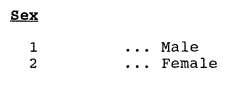

Semua nilai Feature  secara medis memungkinkan terjadi, maka outiler tidak akan di hapus

Melihat Distribusinya Terhadap Target

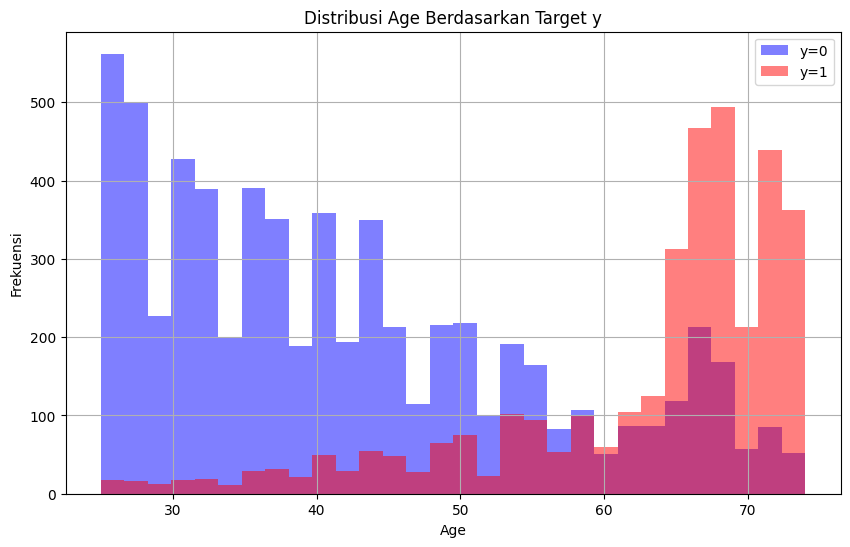

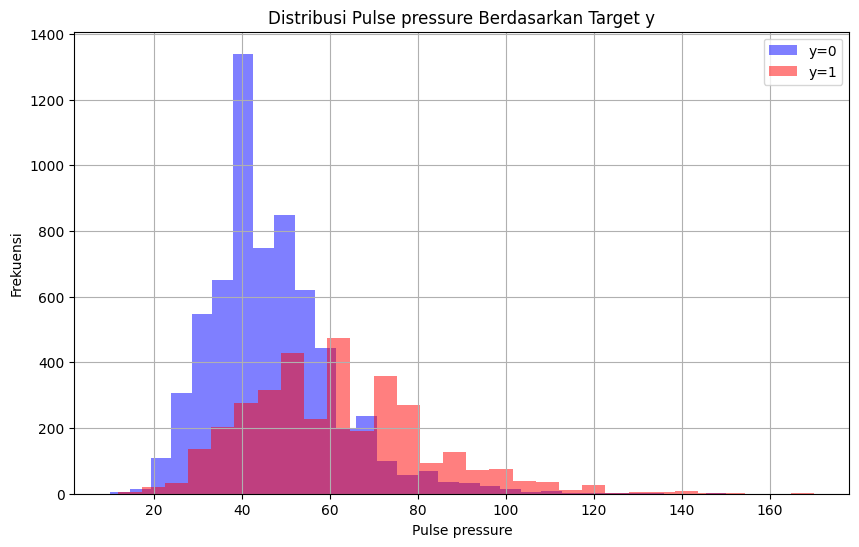

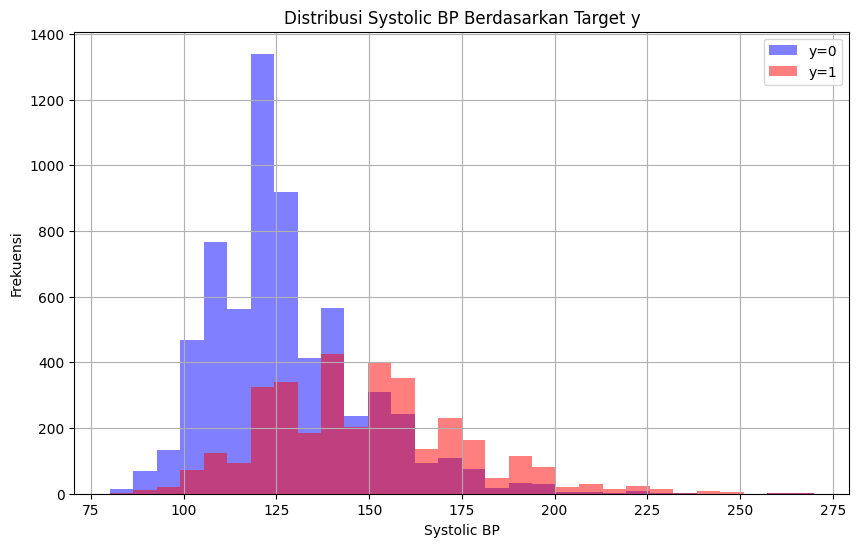

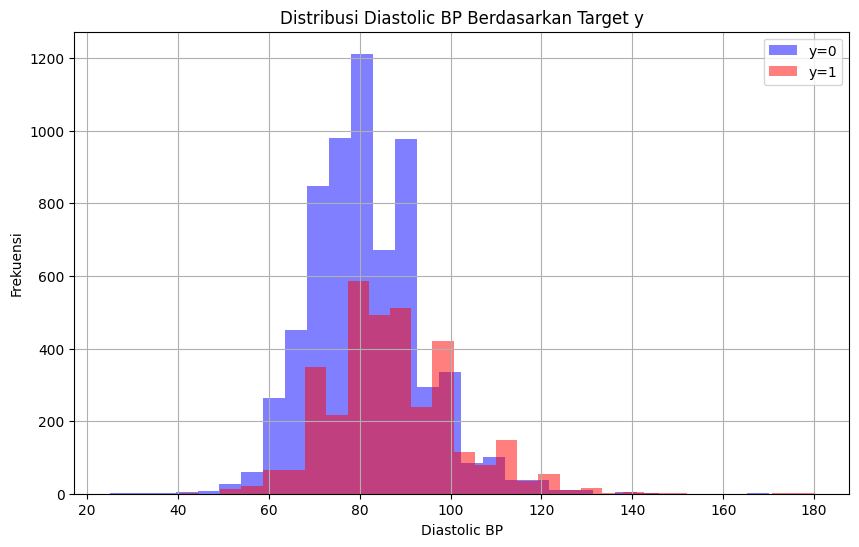

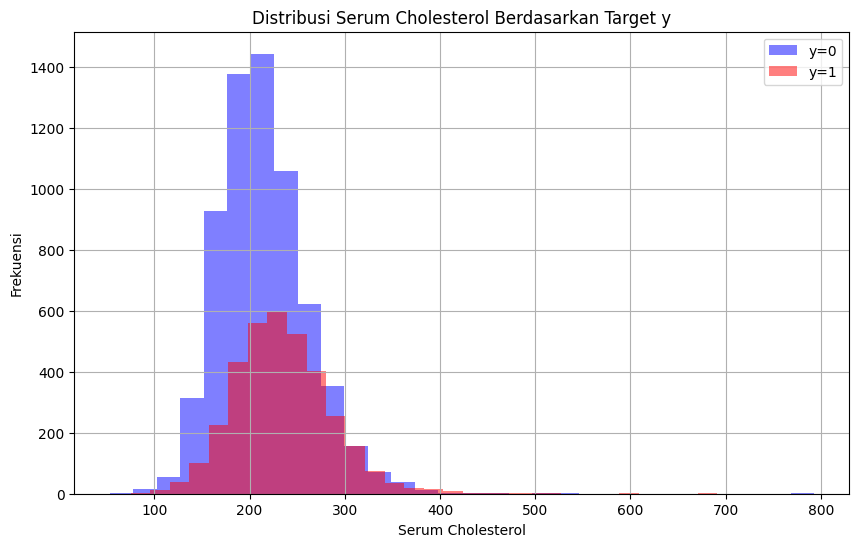

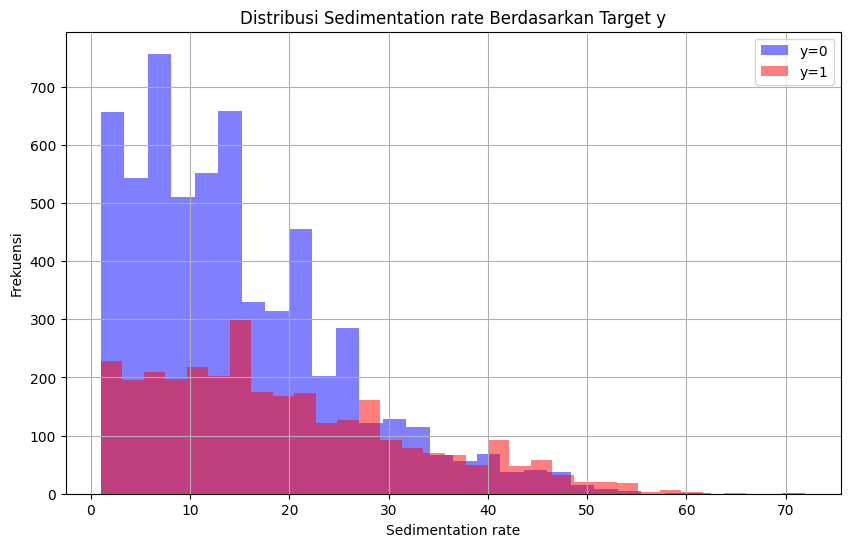

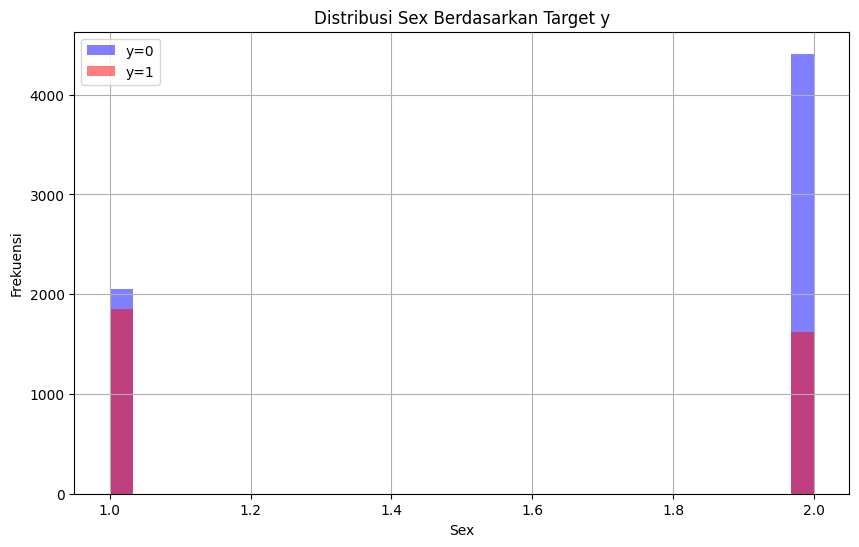

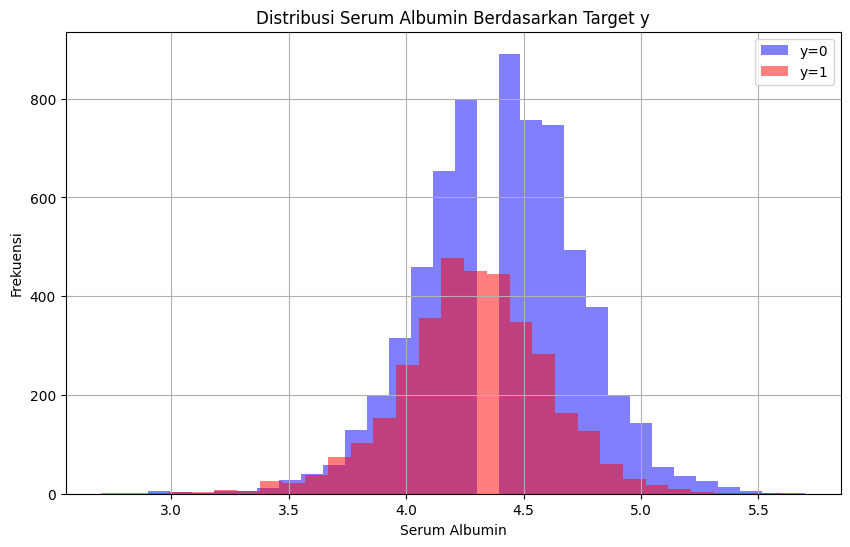

In [137]:
for column in df.columns:
    if column != 'y':  # Menghindari kolom 'y'
        plt.figure(figsize=(10, 6))
        df[df['y'] == 0][column].hist(alpha=0.5, color='blue', bins=30, label='y=0')
        df[df['y'] == 1][column].hist(alpha=0.5, color='red', bins=30, label='y=1')

        plt.legend()
        plt.title(f'Distribusi {column} Berdasarkan Target y')
        plt.xlabel(column)
        plt.ylabel('Frekuensi')
        plt.show()

Kesimpulan Hasil :

**Age**
- Secara umum, grafik menunjukkan bahwa semakin tua usia seseorang, semakin tinggi risiko kematian dalam 10 tahun ke depan (y = 1). Sebaliknya, pada usia yang lebih muda, kemungkinan untuk tetap hidup dalam 10 tahun ke depan jauh lebih tinggi (y = 0).
- Ada pergeseran yang jelas dari dominasi y = 0 pada usia muda ke dominasi y = 1 pada usia tua, yang merupakan pola umum dalam studi epidemiologi dan kesehatan.

**Pulse Plessure:**

- Tekanan nadi yang lebih rendah (30-50 mmHg) lebih sering ditemukan pada individu yang tidak berisiko.
- Tekanan nadi yang lebih tinggi cenderung lebih banyak pada individu yang berisiko, walaupun ada juga beberapa individu tidak berisiko di rentang yang sama.

**Systolic BP**
- Individu yang tidak berisiko (y = 0) cenderung memiliki tekanan darah sistolik yang lebih rendah dan lebih terpusat dalam kisaran normal.
- Sebaliknya, individu yang berisiko (y = 1) lebih banyak ditemukan pada rentang tekanan darah yang lebih tinggi, yang menunjukkan adanya korelasi antara tekanan darah sistolik tinggi dengan peningkatan risiko.

**Diatolic BP**
- Tekanan darah diastolik normal atau lebih rendah (sekitar 70-80 mmHg) lebih sering ditemukan pada individu yang tidak berisiko.
- Sedangkan, individu dengan tekanan diastolik yang lebih tinggi (lebih dari 90 mmHg) lebih banyak ditemukan pada kelompok yang berisiko, meskipun distribusinya lebih sedikit dibandingkan kelompok tidak berisiko.

**Serum Colestrol**

- Kelompok tidak berisiko (y = 0) cenderung lebih terpusat di kisaran 200 mg/dL, menunjukkan bahwa kadar kolesterol yang berada dalam batas normal lebih umum di antara mereka.
- Sebaliknya, individu yang berisiko (y = 1) memiliki distribusi yang lebih merata pada kisaran kadar kolesterol yang lebih tinggi (200-300 mg/dL atau lebih), yang mungkin mengindikasikan hubungan antara kadar kolesterol tinggi dengan peningkatan risiko.

**Sendimentation Rate**
- Laju sedimentasi yang rendah (sekitar 0-15 mm/jam) lebih banyak ditemukan pada individu yang tidak berisiko, menunjukkan bahwa laju sedimentasi yang lebih rendah bisa menjadi indikator status kesehatan yang lebih baik.
- Sebaliknya, laju sedimentasi yang lebih tinggi cenderung lebih sering ditemukan pada individu yang berisiko, yang mungkin menunjukkan adanya inflamasi atau kondisi kesehatan lainnya yang bisa meningkatkan risiko kematian.


**Kesimpulan :**
- Age , Systolic BP, Pulse Presurre, Diastolic BP yang lebih tinggi cenderung lebih banyak pada individu yang berisiko, walaupun ada juga beberapa individu tidak berisiko di rentang yang sama.
- Serum kolesterol dan sedimentation rate memiliki perbedaan distribusi kecil antara y=0 dan y=1, sehingga kurang efektif sebagai prediktor tunggal. Sebaliknya, serum albumin menunjukkan perbedaan yang lebih jelas, dengan y=1 cenderung memiliki nilai lebih rendah, menjadikannya lebih relevan sebagai prediktor risiko.
- Semakin tua usia, semakin tinggi risiko kematian dalam 10 tahun (y=1). Pria lebih dominan di kelompok y=1 (kematian dalam 10 tahun), menunjukkan kerentanan yang lebih tinggi dibanding wanita.

### Cek Missing Data

Looking at our data in , we see that some of the data is missing: some values in the output of the previous cell are marked as `NaN` ("not a number").

Missing data is a common occurrence in data analysis, that can be due to a variety of reasons, such as measuring instrument malfunction, respondents not willing or not able to supply information, and errors in the data collection process.

Let's examine the missing data pattern. `seaborn` is an alternative to `matplotlib` that has some convenient plotting functions for data analysis. We can use its `heatmap` function to easily visualize the missing data pattern.

Run the cell below to plot the missing data:

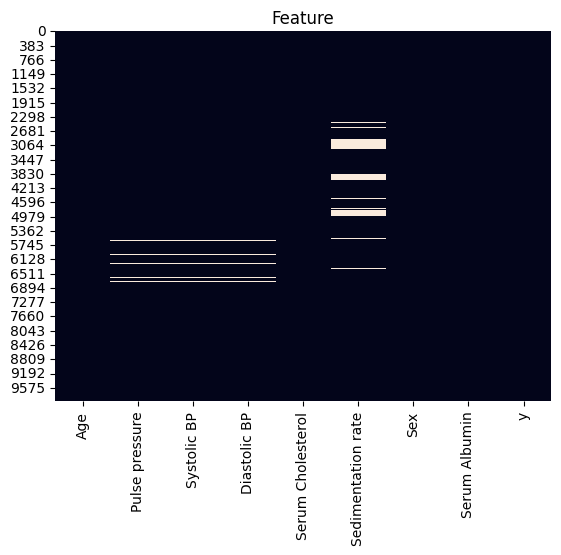

In [138]:
sns.heatmap(df.isnull(), cbar=False)
plt.title("Feature")
plt.show()

For each feature, represented as a column, values that are present are shown in black, and missing values are set in a light color.


Dalam Grafik Terlihat bahwa kolom yang terang meiliki missing value adalah Pulse pressure , Systolic BP, Diastolic BP, Dan Sendimention rate




In the cell below, write a function to compute the fraction of cases with missing data. This will help us decide how we handle this missing data in the future.

<details>    
<summary>
    <font size="3" color="darkgreen"><b>Hints</b></font>
</summary>
<p>
<ul>
    <li> The <code>pandas.DataFrame.isnull()</code> method is helpful in this case.</li>
    <li> Use the <code>pandas.DataFrame.any()</code> method and set the <code>axis</code> parameter.</li>
    <li> Divide the total number of rows with missing data by the total number of rows. Remember that in Python, <code>True</code> values are equal to 1.</li>
</ul>
</p>

In [139]:
# Menghitung jumlah missing values dan persentasenya
missing_values = df.isnull().sum()
missing_percentage = (missing_values / len(df)) * 100
# Membuat DataFrame untuk melihat hasil lebih rapi
missing_data = pd.DataFrame({
    'Kolom': df.columns,
    'Missing Values': missing_values,
    'Persentase (%)': missing_percentage
})

# Menampilkan hanya kolom dengan missing values
missing_data_filtered = missing_data[missing_data['Missing Values'] > 0]
print(missing_data_filtered)

                                 Kolom  Missing Values  Persentase (%)
Pulse pressure          Pulse pressure              59        0.594039
Systolic BP                Systolic BP              57        0.573903
Diastolic BP              Diastolic BP              58        0.583971
Sedimentation rate  Sedimentation rate             826        8.316553


### Menghandle Missing Value dengan K-Nearest Neighbors Imputer

Akan menghandle Missing Value dengan K-Nearest Neighbors, karena Lebih akurat daripada imputasi mean atau median, terutama jika ada korelasi antara variabel.

In [140]:
imputer = KNNImputer(n_neighbors=5)
df[['Pulse pressure', 'Systolic BP', 'Diastolic BP', 'Sedimentation rate']] = imputer.fit_transform(df[['Pulse pressure', 'Systolic BP', 'Diastolic BP', 'Sedimentation rate']])


<ipython-input-140-d9488ba9331c>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[['Pulse pressure', 'Systolic BP', 'Diastolic BP', 'Sedimentation rate']] = imputer.fit_transform(df[['Pulse pressure', 'Systolic BP', 'Diastolic BP', 'Sedimentation rate']])


In [141]:

# Hasil setelah imputasi
print(df)

       Age  Pulse pressure  Systolic BP  Diastolic BP  Serum Cholesterol  \
0     35.0            50.0        142.0          92.0              165.0   
1     71.0            78.0        156.0          78.0              298.0   
2     74.0            84.0        170.0          86.0              222.0   
3     64.0            80.0        172.0          92.0              265.0   
4     32.0            58.0        128.0          70.0              203.0   
...    ...             ...          ...           ...                ...   
9927  26.0            28.0        104.0          76.0              137.0   
9928  69.0            48.0        130.0          82.0              301.0   
9929  34.0            30.0        110.0          80.0              161.0   
9930  57.0            46.0        130.0          84.0              210.0   
9931  70.0            62.0        132.0          70.0              205.0   

      Sedimentation rate  Sex  Serum Albumin  y  
0                   12.0  2.0        

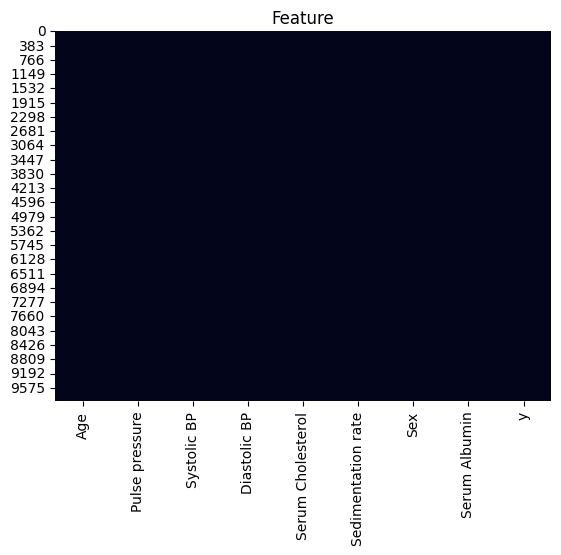

In [142]:
sns.heatmap(df.isnull(), cbar=False)
plt.title("Feature")
plt.show()

Cek kembali corelation

In [143]:
# Menghitung matriks korelasi dengan mengecualikan kolom Cholesterol_Category
correlation_matrix2 = df.corr()

# Menampilkan matriks korelasi
print(correlation_matrix2)

                         Age  Pulse pressure  Systolic BP  Diastolic BP  \
Age                 1.000000        0.501855     0.506531      0.260179   
Pulse pressure      0.501855        1.000000     0.853910      0.226159   
Systolic BP         0.506531        0.853910     1.000000      0.698703   
Diastolic BP        0.260179        0.226159     0.698703      1.000000   
Serum Cholesterol   0.346071        0.188387     0.226516      0.166257   
Sedimentation rate  0.205756        0.192955     0.171577      0.057710   
Sex                -0.159728       -0.023974    -0.091601     -0.138993   
Serum Albumin      -0.202611       -0.097125    -0.064564      0.012835   
y                   0.624231        0.391320     0.403597      0.218530   

                    Serum Cholesterol  Sedimentation rate       Sex  \
Age                          0.346071            0.205756 -0.159728   
Pulse pressure               0.188387            0.192955 -0.023974   
Systolic BP                  0.22651

### Feature Engineering

In [144]:


# labels = [1, 2, 3]  # 1: Muda, 2: Dewasa, 3: Lansia

# # Mengkategorikan kolom Age
# df['Age_Group'] = pd.cut(df['Age'], bins=bins, labels=labels, right=True)

# print(df[['Age', 'Age_Group']].head())


Feature Selection :

In [145]:
# from sklearn.feature_selection import SelectKBest, chi2
# import scipy.stats as stats
# # Uji Chi-Square untuk setiap fitur kategorik terhadap target
# results = []
# for col in ['Age_Group', 'Sex']:
#     contingency_table = pd.crosstab(df[col], df['y'])
#     chi2, p, dof, expected = stats.chi2_contingency(contingency_table)
#     results.append({'Feature': col, 'Chi-Squared Score': chi2, 'P-Value': p})

# # Buat DataFrame hasil uji Chi-Square
# feature_scores = pd.DataFrame(results).set_index('Feature')

# # Visualisasi dengan heatmap
# plt.figure(figsize=(5, 5))
# sns.heatmap(feature_scores[['Chi-Squared Score']].sort_values(by='Chi-Squared Score', ascending=False),
#             annot=True, cmap='Blues', linewidths=0.4, linecolor='black', fmt='.2f')
# plt.title('Chi-Square Test for Categorical Features')
# plt.show()

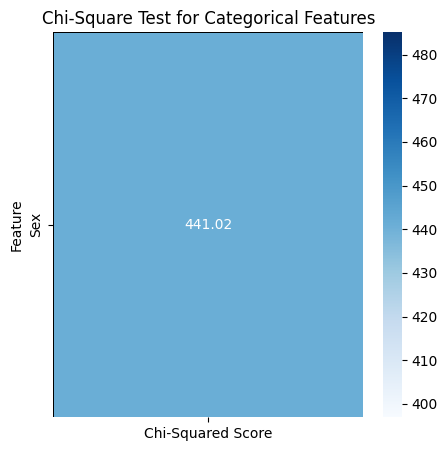

In [146]:
# Uji Chi-Square untuk setiap fitur kategorik terhadap target
results = []
for col in ['Sex']:
    contingency_table = pd.crosstab(df[col], df['y'])
    chi2, p, dof, expected = stats.chi2_contingency(contingency_table)
    results.append({'Feature': col, 'Chi-Squared Score': chi2, 'P-Value': p})

# Buat DataFrame hasil uji Chi-Square
feature_scores = pd.DataFrame(results).set_index('Feature')

# Visualisasi dengan heatmap
plt.figure(figsize=(5, 5))
sns.heatmap(feature_scores[['Chi-Squared Score']].sort_values(by='Chi-Squared Score', ascending=False),
            annot=True, cmap='Blues', linewidths=0.4, linecolor='black', fmt='.2f')
plt.title('Chi-Square Test for Categorical Features')
plt.show()

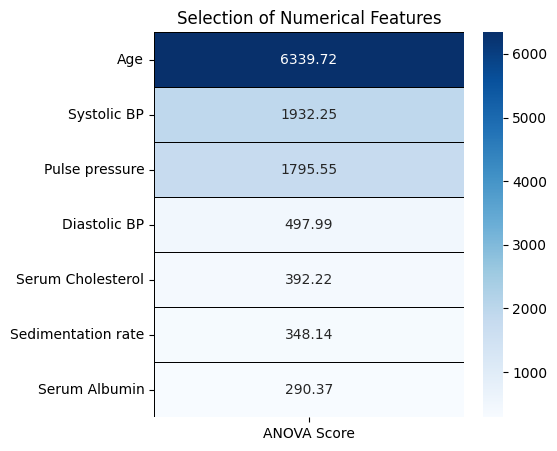

In [147]:
# Tentukan fitur dan target1 (pastikan target1 adalah kategori untuk f_classif)
features1 = df[['Pulse pressure', 'Systolic BP', 'Diastolic BP',
               'Serum Cholesterol', 'Sedimentation rate', 'Serum Albumin','Age']]
target1 = df['y']

# SelectKBest dengan ANOVA F-Test untuk pemilihan fitur numerik
best_features = SelectKBest(score_func=f_classif, k='all')
fit = best_features.fit(features1, target1)

# Buat DataFrame dengan skor ANOVA
feature_scores = pd.DataFrame(data=fit.scores_,
                              index=features1.columns,
                              columns=['ANOVA Score'])

# Visualisasi dengan heatmap
plt.figure(figsize=(5, 5))
sns.heatmap(feature_scores.sort_values(by='ANOVA Score', ascending=False),
            annot=True, cmap='Blues', linewidths=0.4, linecolor='black', fmt='.2f')
plt.title('Selection of Numerical Features')
plt.show()

Dari Hasil di atas kita akan mencoba mengunakan semua variabel dan mencba juga tanpa serum albumin dan sex nanti akan di compare hasil mana yang bagus, dan ternyata mengunakan serum albumin dan sex dapat meningkatkan C index jadi variabel tersebut tetap di gunakan

Variabel yang di gunakan untuk
modelling :
"Age"
,
"Pulse pressure"
,
"Systolic BP"
,
"Diastolic BP"
,
"Serum Cholesterol"
,
"Sedimentation rate"
,
"Sex"
,
"Serum Albumin”

### Cek Imbalance

In [148]:
# Menghitung jumlah nilai dalam kolom 'target'
Kolom_target = df['y'].value_counts()

# Menampilkan hasil
print(Kolom_target)

y
0    6459
1    3473
Name: count, dtype: int64


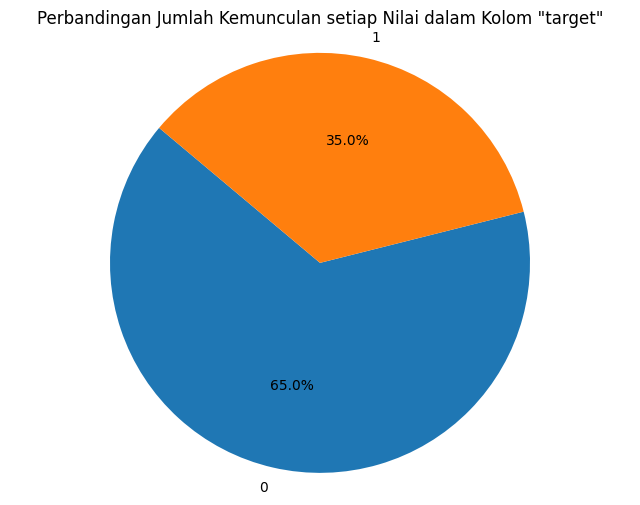

In [149]:
# Plot pie chart
plt.figure(figsize=(8, 6))
plt.pie(Kolom_target, labels=Kolom_target.index, autopct='%1.1f%%', startangle=140)
plt.title('Perbandingan Jumlah Kemunculan setiap Nilai dalam Kolom "target"')
plt.axis('equal')  # Agar pie chart menjadi lingkaran
plt.show()

In [150]:
data = df[["Age","Pulse pressure","Systolic BP","Diastolic BP","Serum Cholesterol","Sedimentation rate","Sex","Serum Albumin","y"]]

In [151]:
# data = df_combined[["Age","Pulse pressure","Systolic BP","Diastolic BP","Serum Cholesterol","Sedimentation rate","y"]]

In [152]:
data

,Age,Pulse pressure,Systolic BP,Diastolic BP,Serum Cholesterol,Sedimentation rate,Sex,Serum Albumin,y
0,35.0,50.0,142.0,92.0,165.0,12.0,2.0,5.0,1
1,71.0,78.0,156.0,78.0,298.0,37.0,2.0,4.0,1
2,74.0,84.0,170.0,86.0,222.0,31.0,2.0,3.8,1
3,64.0,80.0,172.0,92.0,265.0,30.0,2.0,4.3,0
4,32.0,58.0,128.0,70.0,203.0,18.0,1.0,5.0,0
...,...,...,...,...,...,...,...,...,...
9927,26.0,28.0,104.0,76.0,137.0,9.0,1.0,4.7,1
9928,69.0,48.0,130.0,82.0,301.0,18.0,2.0,4.7,0
9929,34.0,30.0,110.0,80.0,161.0,10.0,2.0,4.5,0
9930,57.0,46.0,130.0,84.0,210.0,5.0,1.0,4.5,0


## Modelling

In [153]:
X = data.drop(columns=['y'])
y = data['y']

In [154]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75, random_state=0)


###  Decision Trees


In [155]:
dt = DecisionTreeClassifier(max_depth=None, random_state=10)
dt.fit(X_train, y_train)

DecisionTreeClassifier(random_state=10)

Next we will evaluate our model. We'll use C-Index for evaluation.

> Remember from milestone 1 that the C-Index evaluates the ability of a model to differentiate between different classes, by quantifying how often, when considering all pairs of patients (A, B), the model says that patient A has a higher risk score than patient B when, in the observed data, patient A actually died and patient B actually lived. In our case, our model is a binary classifier, where each risk score is either 1 (the model predicts that the patient will die) or 0 (the patient will live).
>
> More formally, defining _permissible pairs_ of patients as pairs where the outcomes are different, _concordant pairs_ as permissible pairs where the patient that died had a higher risk score (i.e. our model predicted 1 for the patient that died and 0 for the one that lived), and _ties_ as permissible pairs where the risk scores were equal (i.e. our model predicted 1 for both patients or 0 for both patients), the C-Index is equal to:
>
> $$\text{C-Index} = \frac{\#\text{concordant pairs} + 0.5\times \#\text{ties}}{\#\text{permissible pairs}}$$

Run the next cell to compute the C-Index on the train and validation set (we've given you an implementation this time).

In [156]:
pip install lifelines

In [157]:
# Prediksi pada data latih
y_train_preds = dt.predict_proba(X_train)[:, 1]
train_c_index = concordance_index(y_train, y_train_preds)
print(f"Train C-Index: {train_c_index}")

# Prediksi pada data uji
y_test_preds = dt.predict_proba(X_test)[:, 1]
val_c_index = concordance_index(y_test, y_test_preds)
print(f"test C-Index: {val_c_index}")


Train C-Index: 1.0
test C-Index: 0.7179872462329758


#### Hyperparameter Tunning

<details>    
<summary>
    <font size="3" color="darkgreen"><b>Hints</b></font>
</summary>
<p>
<ul>
    <li> Try limiting the depth of the tree (<code>'max_depth'</code>).</li>
</ul>
</p>

In [158]:


# Experiment with different hyperparameters for the DecisionTreeClassifier
# until you get a c-index above 0.6 for the validation set
dt_hyperparams = {
    # set your own hyperparameters below, such as 'min_samples_split': 1

    ### START CODE HERE ###

    'max_depth' : 5

    ### END CODE HERE ###
}

Run the next cell to fit and evaluate the regularized tree.

In [159]:
# Inisialisasi dan pelatihan model
dt_reg = DecisionTreeClassifier(**dt_hyperparams, random_state=10)
dt_reg.fit(X_train, y_train)

# Prediksi probabilitas
y_train_preds = dt_reg.predict_proba(X_train)[:, 1]
y_test_preds = dt_reg.predict_proba(X_test)[:, 1]

# Hitung dan tampilkan C-Index
train_cindex = concordance_index(y_train, y_train_preds)
test_cindex = concordance_index(y_test, y_test_preds)

print(f"Train C-Index: {train_cindex}")
print(f"Test C-Index (expected > 0.6): {test_cindex}")


Train C-Index: 0.8865501435435521
Test C-Index (expected > 0.6): 0.8836026254735962


If you used a low `max_depth` you can print the entire tree. This allows for easy interpretability. Run the next cell to print the tree splits.

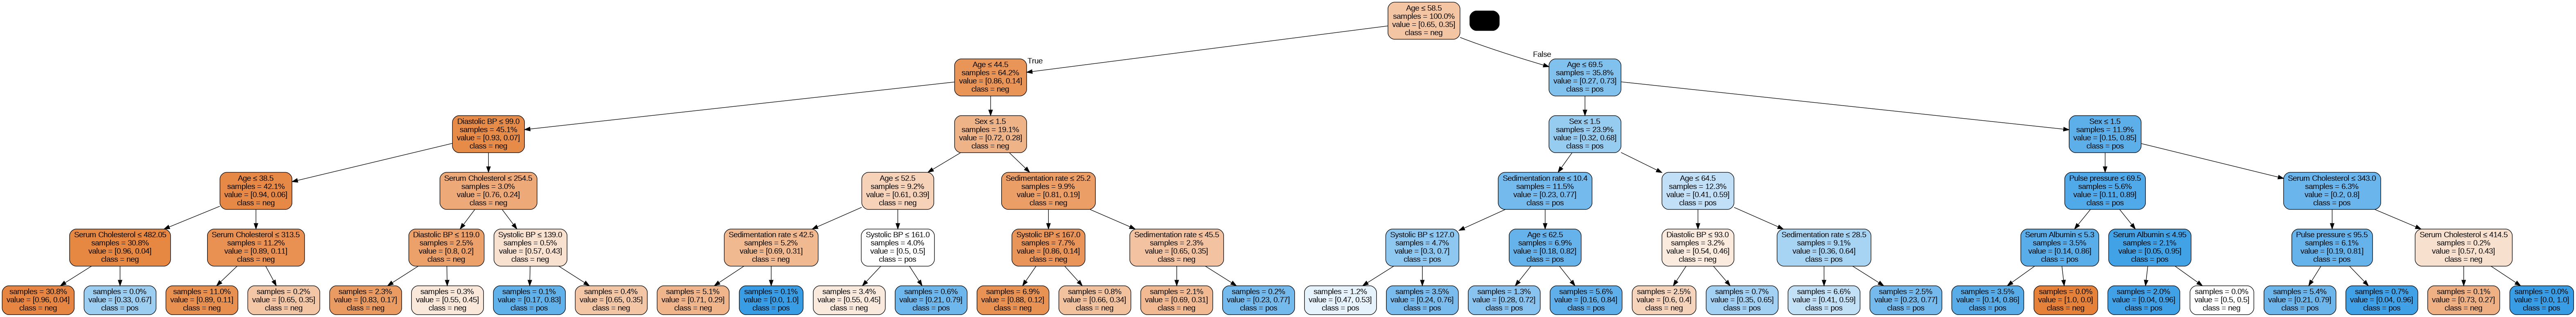

In [160]:
dot_data = StringIO()
export_graphviz(dt_reg, feature_names=X_train.columns, out_file=dot_data,
                filled=True, rounded=True, proportion=True, special_characters=True,
                impurity=False, class_names=['neg', 'pos'], precision=2)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
Image(graph.create_png())


> **Overfitting, underfitting, and the bias-variance tradeoff**
>
> If you tested several values of `max_depth`, you may have seen that a value of `3` gives training and validation C-Indices of about `0.689` and `0.630`, and that a `max_depth` of `2` gives better agreement with values of about `0.653` and `0.607`. In the latter case, we have further reduced overfitting, at the cost of a minor loss in predictive performance.
>
> Contrast this with a `max_depth` value of `1`, which results in C-Indices of about `0.597` for the training set and `0.598` for the validation set: we have eliminated overfitting but with a much stronger degradation of predictive performance.
>
> Lower predictive performance on the training and validation sets is indicative of the model _underfitting_ the data: it neither learns enough from the training data nor is able to generalize to unseen data (the validation data in our case).
>
> Finding a model that minimizes and acceptably balances underfitting and overfitting (e.g. selecting the model with a `max_depth` of `2` over the other values) is a common problem in machine learning that is known as the _bias-variance tradeoff_.

### 6. Random Forests

No matter how you choose hyperparameters, a single decision tree is prone to overfitting. To solve this problem, you can try **random forests**, which combine predictions from many different trees to create a robust classifier.

As before, we will use scikit-learn to build a random forest for the data. We will use the default hyperparameters.

In [161]:
rf = RandomForestClassifier(n_estimators=100, random_state=10)
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=10)

Now compute and report the C-Index for the random forest on the training and validation set.

In [162]:
# Prediksi probabilitas dengan model RandomForest
y_train_rf_preds = rf.predict_proba(X_train)[:, 1]
y_test_rf_preds = rf.predict_proba(X_test)[:, 1]

# Hitung dan tampilkan C-Index
train_cindex = concordance_index(y_train, y_train_rf_preds)
test_cindex = concordance_index(y_test, y_test_rf_preds)

print(f"Train C-Index: {train_cindex}")
print(f"Test C-Index: {test_cindex}")


Train C-Index: 1.0
Test C-Index: 0.8807057920981972


#### Hyperparameter Tunning

Training a random forest with the default hyperparameters results in a model that has better predictive performance than individual decision trees as in the previous section, but this model is overfitting.

We therefore need to tune (or optimize) the hyperparameters, to find a model that both has good predictive performance and minimizes overfitting.

The hyperparameters we choose to adjust will be:

- `n_estimators`: the number of trees used in the forest.
- `max_depth`: the maximum depth of each tree.
- `min_samples_leaf`: the minimum number (if `int`) or proportion (if `float`) of samples in a leaf.

The approach we implement to tune the hyperparameters is known as a grid search:

- We define a set of possible values for each of the target hyperparameters.

- A model is trained and evaluated for every possible combination of hyperparameters.

- The best performing set of hyperparameters is returned.

The cell below implements a hyperparameter grid search, using the C-Index to evaluate each tested model.

In [163]:
def holdout_grid_search(clf, X_train_hp, y_train_hp, X_test_hp, y_test_hp, hyperparams, fixed_hyperparams={}):
    '''
    Conduct hyperparameter grid search on hold out validation set. Use holdout validation.
    Hyperparameters are input as a dictionary mapping each hyperparameter name to the
    range of values they should iterate over. Use concordance_index as your evaluation function.

    Input:
        clf: sklearn classifier
        X_train_hp (dataframe): dataframe for training set input variables
        y_train_hp (dataframe): dataframe for training set targets
        X_test_hp (dataframe): dataframe for validation set input variables
        y_test_hp (dataframe): dataframe for validation set targets
        hyperparams (dict): hyperparameter dictionary mapping hyperparameter
                            names to range of values for grid search
        fixed_hyperparams (dict): dictionary of fixed hyperparameters that
                                  are not included in the grid search

    Output:
        best_estimator (sklearn classifier): fitted sklearn classifier with best performance on
                                             validation set
        best_hyperparams (dict): hyperparameter dictionary mapping hyperparameter
                                 names to values in best_estimator
    '''
    best_estimator = None
    best_hyperparams = {}
    best_score = 0.0  # Initialize the best score to 0

    # Get all possible hyperparameter combinations
    param_combinations = list(itertools.product(*hyperparams.values()))
    total_param_combinations = len(param_combinations)

    # Iterate over all hyperparameter combinations
    for i, params in enumerate(param_combinations, 1):
        # Create a dictionary with current hyperparameters
        param_dict = {param_name: params[param_index]
                      for param_index, param_name in enumerate(hyperparams)}

        # Initialize the classifier with current parameters
        estimator = clf(**param_dict, **fixed_hyperparams)

        # Fit the model
        estimator.fit(X_train_hp, y_train_hp)

        # Get predictions on the validation set
        preds = estimator.predict_proba(X_test_hp)[:, 1]

        # Compute the concordance index
        estimator_score = concordance_index(y_test_hp, preds)

        print(f'[{i}/{total_param_combinations}] {param_dict}')
        print(f'Val C-Index: {estimator_score}\n')

        # Update the best score, estimator, and hyperparameters if a new high score is found
        if estimator_score >= best_score:
            best_score = estimator_score
            best_estimator = estimator
            best_hyperparams = param_dict

    # Add fixed hyperparameters to the best hyperparameters
    best_hyperparams.update(fixed_hyperparams)

    return best_estimator, best_hyperparams



In the cell below, define the values you want to run the hyperparameter grid search on, and run the cell to find the best-performing set of hyperparameters.


<details>    
<summary>
    <font size="3" color="darkgreen"><b>Hints</b></font>
</summary>
<p>
<ul>
    <li>n_estimators: try values greater than 100</li>
    <li>max_depth: try values in the range 1 to 100</li>
    <li>min_samples_leaf: try float values below .5 and/or int values greater than 2</li>
</ul>
</p>

In [164]:
def random_forest_grid_search(X_train, y_train, X_test, y_test):
    # Define ranges for the chosen random forest hyperparameters
    hyperparams = {
        'n_estimators': [150, 170, 200],  # Jumlah pohon
        'max_depth': [5, 6, 7],           # Kedalaman maksimum pohon
        'min_samples_leaf': [3, 4],       # Jumlah sampel minimum pada daun
    }

    fixed_hyperparams = {'random_state': 10}

    # Inisialisasi RandomForestClassifier
    rf = RandomForestClassifier

    # Panggil fungsi holdout_grid_search (asumsikan ini telah didefinisikan)
    best_rf, best_hyperparams = holdout_grid_search(
        rf, X_train, y_train, X_test, y_test, hyperparams, fixed_hyperparams
    )

    print(f"Best hyperparameters:\n{best_hyperparams}")

    # Prediksi probabilitas untuk C-Index
    y_train_best = best_rf.predict_proba(X_train)[:, 1]
    train_cindex = concordance_index(y_train, y_train_best)
    print(f"Train C-Index: {train_cindex}")

    y_test_best = best_rf.predict_proba(X_test)[:, 1]
    test_cindex = concordance_index(y_test, y_test_best)
    print(f"Test C-Index: {test_cindex}")

    # Tambahkan hyperparams tetap ke kombinasi terbaik
    best_hyperparams.update(fixed_hyperparams)

    return best_rf, best_hyperparams


In [165]:
best_rf, best_hyperparams = random_forest_grid_search(X_train, y_train, X_test, y_test)

[1/18] {'n_estimators': 150, 'max_depth': 5, 'min_samples_leaf': 3}
Val C-Index: 0.8881239813313598

[2/18] {'n_estimators': 150, 'max_depth': 5, 'min_samples_leaf': 4}
Val C-Index: 0.8879411022369

[3/18] {'n_estimators': 150, 'max_depth': 6, 'min_samples_leaf': 3}
Val C-Index: 0.890961993945383

[4/18] {'n_estimators': 150, 'max_depth': 6, 'min_samples_leaf': 4}
Val C-Index: 0.8904080093200605

[5/18] {'n_estimators': 150, 'max_depth': 7, 'min_samples_leaf': 3}
Val C-Index: 0.8914261432260585

[6/18] {'n_estimators': 150, 'max_depth': 7, 'min_samples_leaf': 4}
Val C-Index: 0.891076070573506

[7/18] {'n_estimators': 170, 'max_depth': 5, 'min_samples_leaf': 3}
Val C-Index: 0.8882733504163084

[8/18] {'n_estimators': 170, 'max_depth': 5, 'min_samples_leaf': 4}
Val C-Index: 0.8880270161974553

[9/18] {'n_estimators': 170, 'max_depth': 6, 'min_samples_leaf': 3}
Val C-Index: 0.8910446995007721

[10/18] {'n_estimators': 170, 'max_depth': 6, 'min_samples_leaf': 4}
Val C-Index: 0.890471464444

#### Simpan Model

In [166]:
# Simpan model terbaik ke file .pkl
with open('best_rf_model.pkl', 'wb') as file:
    pickle.dump(best_rf, file)

print("Model telah berhasil disimpan ke 'best_rf_model.pkl'!")

Model telah berhasil disimpan ke 'best_rf_model.pkl'!


## 11. Explanations: SHAP

Using a random forest has improved results, but we've lost some of the natural interpretability of trees. In this section we'll try to explain the predictions using slightly more sophisticated techniques.

You choose to apply **SHAP (SHapley Additive exPlanations) **, a cutting edge method that explains predictions made by black-box machine learning models (i.e. models which are too complex to be understandable by humans as is).

> Given a prediction made by a machine learning model, SHAP values explain the prediction by quantifying the additive importance of each feature to the prediction. SHAP values have their roots in cooperative game theory, where Shapley values are used to quantify the contribution of each player to the game.
>
> Although it is computationally expensive to compute SHAP values for general black-box models, in the case of trees and forests there exists a fast polynomial-time algorithm. For more details, see the [TreeShap paper](https://arxiv.org/pdf/1802.03888.pdf).

We'll use the [shap library](https://github.com/slundberg/shap) to do this for our random forest model. Run the next cell to output the most at risk individuals in the test set according to our model.

In [167]:
# import shap
# import matplotlib.pyplot as plt

# # Salin X_test dan tambahkan kolom risiko
# X_test_risk = X_test.copy(deep=True)
# X_test_risk['risk'] = best_rf.predict_proba(X_test_risk)[:, 1]
# X_test_risk = X_test_risk.sort_values(by='risk', ascending=False)

# # Buat TreeExplainer untuk model
# explainer = shap.TreeExplainer(best_rf)

# # Pilih instance pertama untuk analisis SHAP
# i = 0
# instance = X_test.loc[[X_test_risk.index[i]]]

# # Hitung SHAP values untuk instance
# shap_values = explainer.shap_values(instance)

# # Cek bentuk `shap_values`
# print(f"SHAP values shape: {shap_values.shape}")

# # Ambil nilai ekspektasi untuk kelas positif
# expected_value = explainer.expected_value[1] if isinstance(explainer.expected_value, list) else explainer.expected_value

# # Ambil SHAP values untuk kelas positif dan instance pertama
# shap_values_for_instance = shap_values[1][0] if isinstance(shap_values, list) else shap_values[0]

# # Visualisasi force plot untuk instance pertama
# shap.plots.force(
#     base_value=expected_value,
#     shap_values=shap_values_for_instance,
#     features=instance.values.flatten(),
#     feature_names=X_test.columns
# )

# # Buat summary plot
# plt.figure()
# shap.summary_plot(shap_values[1], X_test)

# # Membuat dependence plot dengan interaksi pada fitur yang diinginkan
# shap.dependence_plot('Age', shap_values[1], X_test, interaction_index='Sex')
# shap.dependence_plot('Pulse pressure', shap_values[1], X_test, interaction_index='Sex')
# shap.dependence_plot('Systolic BP', shap_values[1], X_test, interaction_index='Sex')
# shap.dependence_plot('Diastolic BP', shap_values[1], X_test, interaction_index='Sex')


In [168]:
X_test_risk = X_test.copy(deep=True)
X_test_risk.loc[:, 'risk'] = best_rf.predict_proba(X_test_risk)[:, 1]
X_test_risk = X_test_risk.sort_values(by='risk', ascending=False)
X_test_risk.head()

,Age,Pulse pressure,Systolic BP,Diastolic BP,Serum Cholesterol,Sedimentation rate,Sex,Serum Albumin,risk
5932,72.0,108.0,218.0,110.0,259.0,26.0,1.0,4.2,0.948750
2946,72.0,100.0,200.0,100.0,247.0,16.8,1.0,4.1,0.947768
2919,71.0,105.0,190.0,85.0,238.0,18.0,1.0,4.2,0.940840
5490,73.0,108.0,230.0,122.0,216.0,14.0,1.0,4.5,0.932221
2036,74.0,110.0,206.0,96.0,175.0,51.0,1.0,4.2,0.927425


### Shap Values

We can use SHAP values to try and understand the model output on specific individuals using force plots. Run the cell below to see a force plot on the riskiest individual.

Instance shape: (1, 8)
SHAP values shape: (1, 8, 2)
SHAP value shape: (8,)


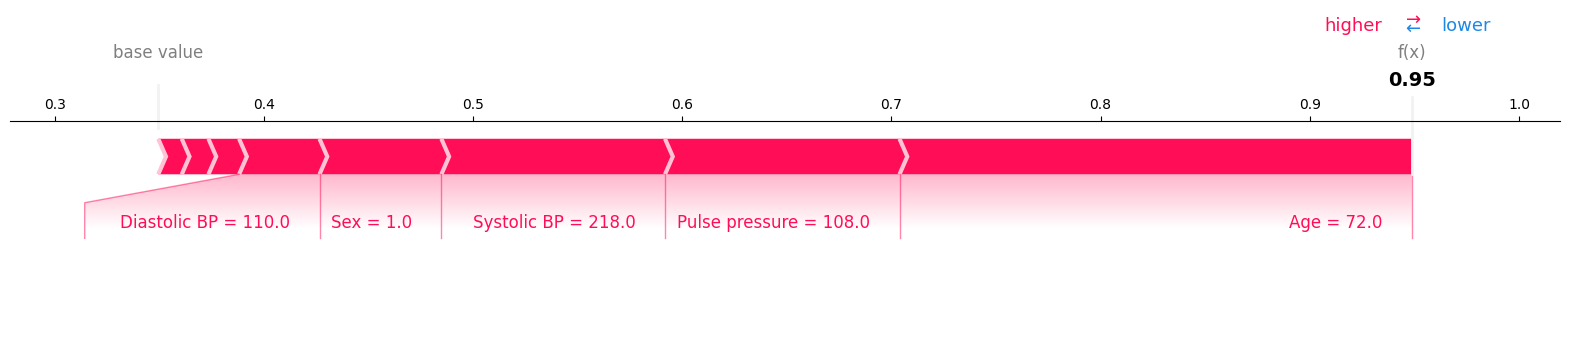

In [169]:
# Buat TreeExplainer untuk model
explainer = shap.TreeExplainer(best_rf)

# Pilih instance pertama untuk analisis SHAP
i = 0
instance = X_test.loc[[X_test_risk.index[i]]]

# Hitung SHAP values untuk instance
shap_values = explainer.shap_values(instance)

# Cek bentuk SHAP values
print(f"Instance shape: {instance.shape}")
print(f"SHAP values shape: {shap_values.shape}")

# Ambil SHAP values untuk kelas positif (kelas 1)
# Kita ambil hanya untuk instance pertama
shap_value = shap_values[i][:, 1].flatten()  # Ambil nilai untuk kelas 1

# Verifikasi bentuk
print(f"SHAP value shape: {shap_value.shape}")

# Visualisasi menggunakan force plot
shap.force_plot(
    explainer.expected_value[1],  # Ekspektasi untuk kelas 1
    shap_value,                   # SHAP values untuk kelas 1
    features=instance.values.flatten(),  # Fitur dari instance
    feature_names=X_test.columns,
    matplotlib=True
)


How to read this chart:
- The red sections on the left are features which push the model towards the final prediction in the positive direction (i.e. a higher Age increases the predicted risk).
- The blue sections on the right are features that push the model towards the final prediction in the negative direction (if an increase in a feature leads to a lower risk, it will be shown in blue).
- Note that the exact output of your chart will differ depending on the hyper-parameters that you choose for your model.

We can also use SHAP values to understand the model output in aggregate. Run the next cell to initialize the SHAP values (this may take a few minutes).

In [170]:
shap_values = shap.TreeExplainer(best_rf).shap_values(X_test)[1]


Run the next cell to see a summary plot of the SHAP values for each feature on each of the test examples. The colors indicate the value of the feature.

In [171]:
# shap.summary_plot(shap_values, X_test)

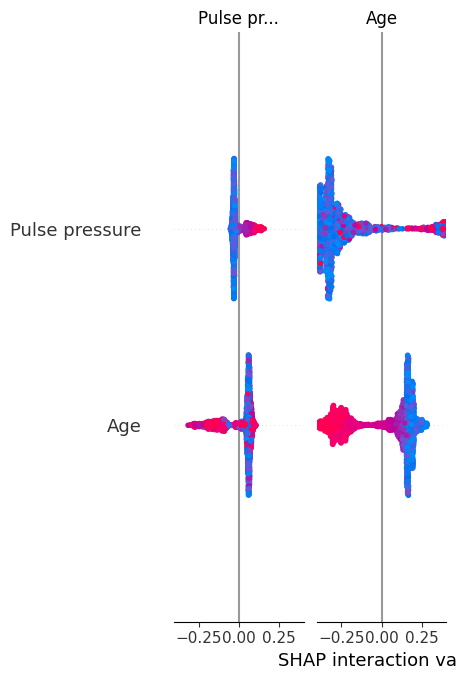

In [172]:
shap_values_all_classes = explainer(X_test)  # Gunakan Explainer secara langsung
shap.summary_plot(shap_values_all_classes.values, X_test, feature_names=X_test.columns)

Clearly we see that being a woman (`sex = 2.0`, as opposed to men for which `sex = 1.0`) has a negative SHAP value, meaning that it reduces the risk of dying within 10 years. High age and high systolic blood pressure have positive SHAP values, and are therefore related to increased mortality.

You can see how features interact using dependence plots. These plot the SHAP value for a given feature for each data point, and color the points in using the value for another feature. This lets us begin to explain the variation in SHAP value for a single value of the main feature.

Run the next cell to see the interaction between Age and Sex.

In [173]:
# # Extract SHAP values for the positive class to get a 2D array
# shap_values_to_plot = shap_values_to_plot[:, :, 1]  # Select SHAP values for the positive class

# # Verify the new shape
# print(f"Final SHAP values shape for plotting: {shap_values_to_plot.shape}")

#### dependence plot pada fitur 'Age' dengan interaksi pada 'Sex'

In [174]:
# Hitung SHAP values untuk seluruh X_test tanpa membatasi pada satu instance atau kelas
shap_values_all = explainer.shap_values(X_test)

# Jika model klasifikasi biner, pilih SHAP values untuk kelas yang diinginkan
# Jika klasifikasi multi-label atau tidak perlu dibagi, abaikan bagian ini
if isinstance(shap_values_all, list):
    shap_values_to_plot = shap_values_all[1]  # Contoh: kelas positif
else:
    shap_values_to_plot = shap_values_all

# Verifikasi bentuk dari SHAP values dan X_test
print(f"Final SHAP values shape for plotting: {shap_values_to_plot.shape}")
print(f"X_test shape: {X_test.shape}")

Final SHAP values shape for plotting: (2483, 8, 2)
X_test shape: (2483, 8)


In [175]:
# Pilih SHAP values untuk kelas positif untuk mendapatkan array berdimensi (2483, 8)
shap_values_to_plot = shap_values_to_plot[..., 1]  # Memilih SHAP values hanya untuk kelas positif

Final SHAP values shape for plotting: (2483, 8)


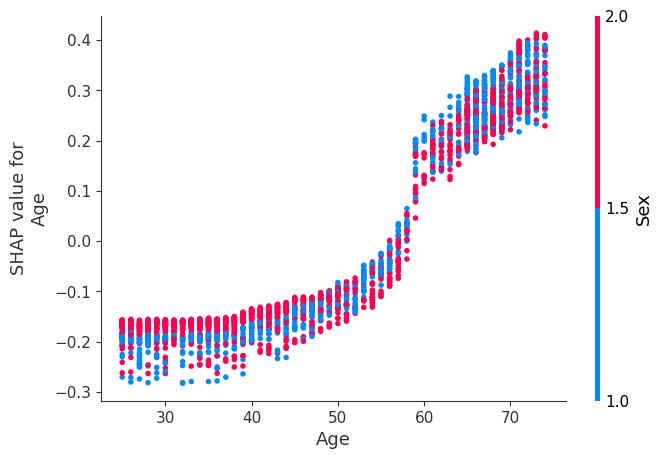

In [176]:
# Verifikasi bentuknya sekali lagi
print(f"Final SHAP values shape for plotting: {shap_values_to_plot.shape}")

# Buat dependence plot pada fitur 'Age' dengan interaksi pada 'Sex'
shap.dependence_plot('Age', shap_values_to_plot, X_test, interaction_index='Sex')



Secara keseluruhan, grafik ini menunjukkan bahwa:

- Usia adalah faktor risiko yang kuat dan signifikan untuk mortalitas, terutama pada usia lanjut.
- Pria pada usia tua (sekitar 60 tahun ke atas) tampaknya lebih berisiko dibandingkan wanita pada usia yang sama, sesuai kontribusi fitur Age.
- Informasi ini dapat digunakan untuk lebih memahami perbedaan risiko kesehatan berdasarkan usia dan jenis kelamin, serta dalam mendesain intervensi yang disesuaikan dengan kelompok usia dan jenis kelamin.

We see that while Age > 50 is generally bad (positive SHAP value), being a woman generally reduces the impact of age. This makes sense since we know that women generally live longer than men.

Let's now look at poverty index and age.

#### 'Age' dengan interaksi pada ' Pulse Pressure'

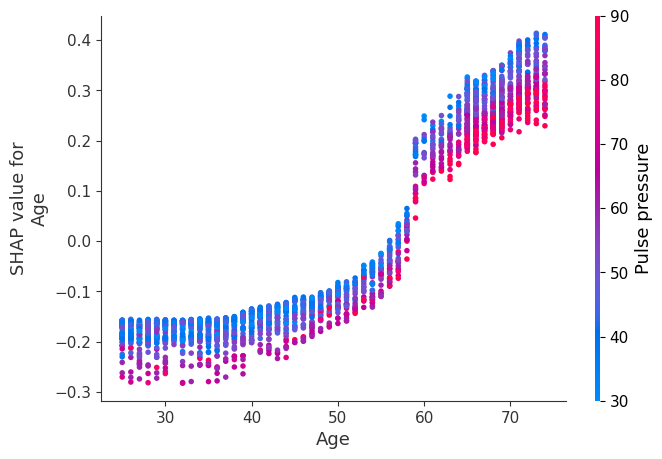

In [177]:
# Dependence plot untuk fitur
shap.dependence_plot('Age', shap_values_to_plot, X_test, interaction_index='Pulse pressure')


Secara keseluruhan, grafik ini menunjukkan bahwa:

- Usia adalah faktor yang sangat berpengaruh dalam meningkatkan risiko.
- Pulse Pressure menjadi semakin signifikan dalam meningkatkan risiko pada - - - kelompok usia yang lebih tua.
- Individu dengan usia lanjut dan tekanan nadi tinggi memiliki risiko yang - lebih tinggi, sesuai prediksi model.

####  fitur 'Age' dengan interaksi pada 'Systolic BP'

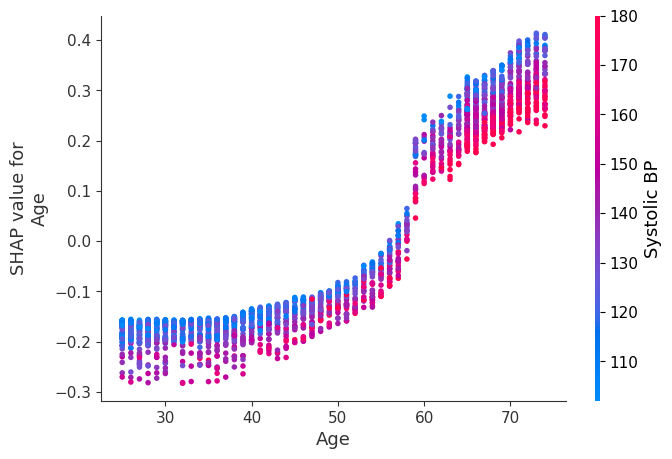

In [178]:
shap.dependence_plot('Age', shap_values_to_plot, X_test, interaction_index='Systolic BP')


- Tekanan darah sistolik tinggi pada usia lanjut (diwakili oleh titik merah) memperbesar kontribusi risiko secara signifikan. Ini menunjukkan bahwa individu dengan usia lanjut dan tekanan darah sistolik tinggi berada pada risiko yang lebih tinggi dalam model.
- Tekanan darah sistolik rendah (diwakili oleh titik biru) pada usia lanjut tetap menunjukkan risiko, tetapi tidak setinggi individu dengan tekanan darah sistolik tinggi pada usia yang sama.

#### 'Age' dengan interaksi pada 'Diastolic BP'

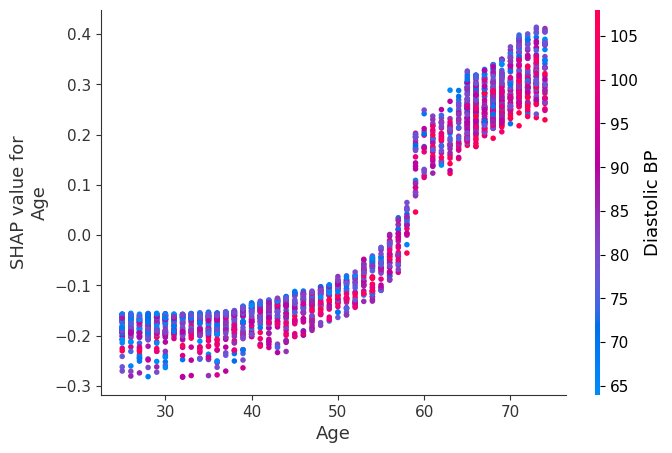

In [179]:
# Dependence plot untuk fitur 'Diastolic BP' dengan interaksi pada 'Sex'
shap.dependence_plot('Age', shap_values_to_plot, X_test, interaction_index='Diastolic BP')


- Tekanan darah diastolik tinggi (warna merah) pada usia lanjut memperbesar kontribusi risiko, yang berarti bahwa individu yang lebih tua dengan tekanan darah diastolik tinggi berisiko lebih tinggi.
- Tekanan darah diastolik rendah (warna biru) pada usia lanjut menunjukkan kontribusi risiko yang lebih rendah, meskipun usia tetap menjadi faktor risiko.

#### 'Age' dengan interaksi pada 'Serum Cholesterol'

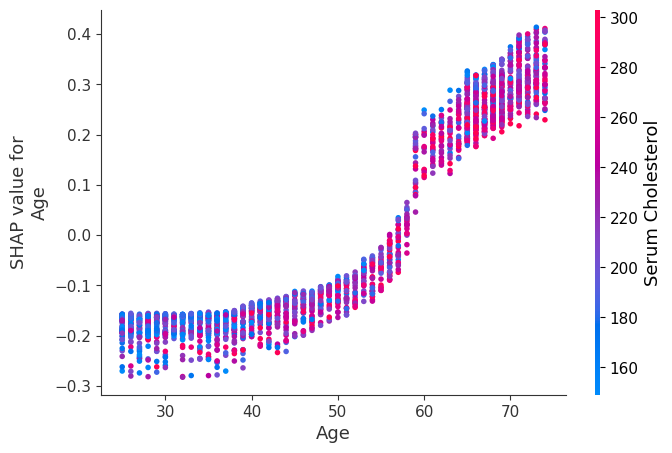

In [180]:
# Dependence plot untuk fitur 'Age' dengan interaksi pada 'erum colestrol'
shap.dependence_plot('Age', shap_values_to_plot, X_test, interaction_index='Serum Cholesterol')


- Kadar kolesterol tinggi (warna merah) memperbesar kontribusi risiko pada usia lanjut, yang menunjukkan bahwa individu yang lebih tua dengan kolesterol tinggi berisiko lebih tinggi.
- Kadar kolesterol rendah (warna biru) pada usia lanjut menunjukkan kontribusi risiko yang lebih rendah, meskipun usia tetap menjadi faktor risiko.

#### 'Age' dengan interaksi pada 'Sedimentation rate'

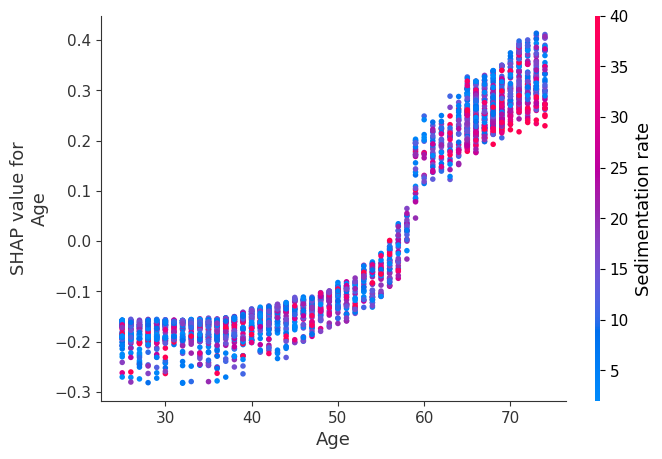

In [181]:
# Dependence plot untuk fitur 'Sedimentation rate' dengan interaksi pada 'Sex'
shap.dependence_plot('Age', shap_values_to_plot, X_test, interaction_index='Sedimentation rate')

- Laju endap darah tinggi (warna merah) pada usia lanjut memperbesar kontribusi risiko, menandakan bahwa individu yang lebih tua dengan laju endap darah tinggi mungkin memiliki risiko kesehatan yang lebih tinggi.
- Laju endap darah rendah (warna biru) pada usia lanjut menunjukkan kontribusi risiko yang lebih rendah, meskipun usia tetap menjadi faktor risiko.

#### 'Age' dengan interaksi pada 'Serum Albumin'

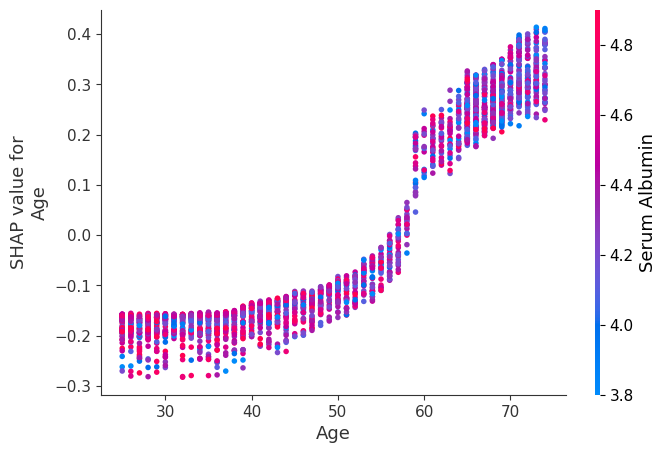

In [182]:
# Dependence plot untuk fitur 'Serum Albumin' dengan interaksi pada 'Sex'
shap.dependence_plot('Age', shap_values_to_plot, X_test, interaction_index='Serum Albumin')

#### 'Pulse pressure' dengan interaksi pada 'Systolic BP'

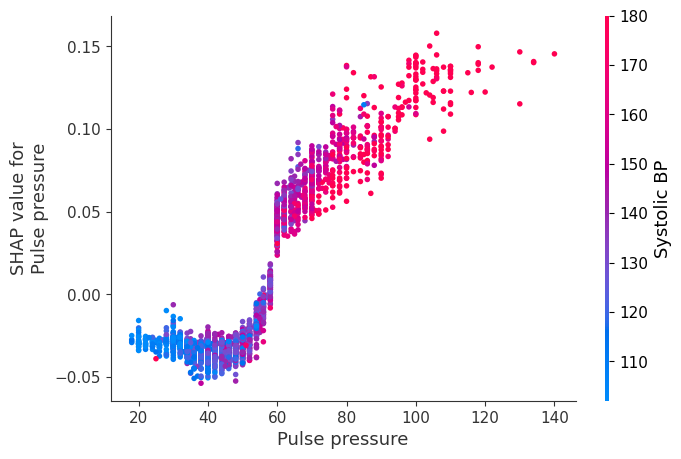

In [183]:
# Dependence plot untuk fitur 'Pulse pressure' dengan interaksi pada 'Systolic BP'
shap.dependence_plot('Pulse pressure', shap_values_to_plot, X_test, interaction_index='Systolic BP')

Grafik ini menyoroti bahwa baik pulse pressure maupun systolic BP berperan dalam meningkatkan risiko kesehatan, terutama ketika keduanya berada pada level tinggi. Kombinasi tekanan nadi yang tinggi dan tekanan darah sistolik yang tinggi memberikan kontribusi risiko yang paling besar dalam prediksi model.

#### Sex dengan Serum Cholesterol:

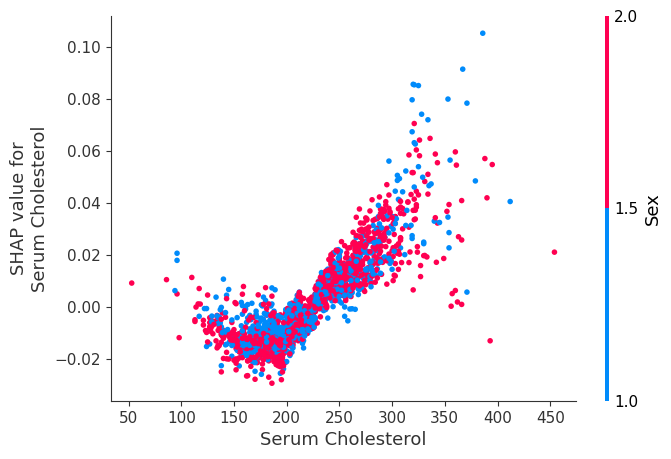

In [184]:
# Dependence plot untuk fitur 'Age' dengan interaksi pada 'Serum Cholesterol'
shap.dependence_plot('Serum Cholesterol', shap_values_to_plot, X_test, interaction_index='Sex')

- Kadar kolesterol tinggi adalah faktor risiko yang signifikan dalam model ini, terutama ketika kadar kolesterol mencapai di atas 250 mg/dL, di mana nilai SHAP meningkat tajam.
- Jenis kelamin (pria atau wanita) tidak tampak memengaruhi cara kadar kolesterol berkontribusi terhadap risiko, karena titik-titik merah dan biru tersebar merata dan tumpang tindih di seluruh grafik.
- Kadar kolesterol rendah menunjukkan kontribusi risiko yang lebih rendah, yang berarti individu dengan kolesterol lebih rendah mungkin memiliki risiko kesehatan yang lebih rendah menurut model.

#### Pulse Pressure dengan Serum Cholesterol:

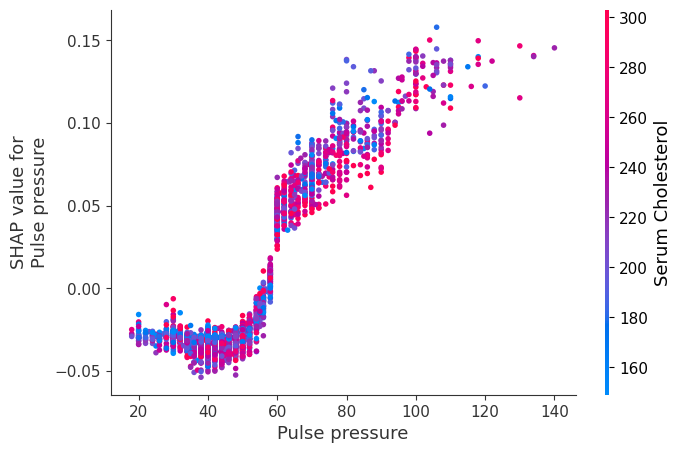

In [185]:
shap.dependence_plot('Pulse pressure', shap_values_to_plot, X_test, interaction_index='Serum Cholesterol')


Grafik ini menyoroti bahwa baik Pulse Pressure maupun Serum Cholesterol berperan dalam meningkatkan risiko kesehatan, terutama ketika keduanya berada pada level tinggi. Kombinasi tekanan nadi yang tinggi dan kolesterol yang tinggi memberikan kontribusi risiko yang paling besar dalam model prediksi ini.

#### Systolic BP dengan Diastolic BP

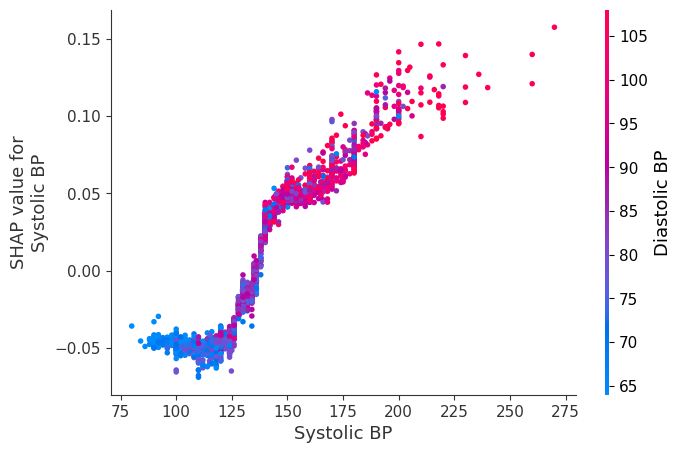

In [186]:
shap.dependence_plot('Systolic BP', shap_values_to_plot, X_test, interaction_index='Diastolic BP')

Grafik ini menyoroti bahwa baik Systolic BP maupun Diastolic BP berperan penting dalam meningkatkan risiko kesehatan, terutama ketika keduanya berada pada level tinggi. Kombinasi tekanan darah sistolik dan diastolik yang tinggi memberikan kontribusi risiko yang paling besar dalam prediksi model ini.

#### Systolic BP dengan Sedimentation Rate:

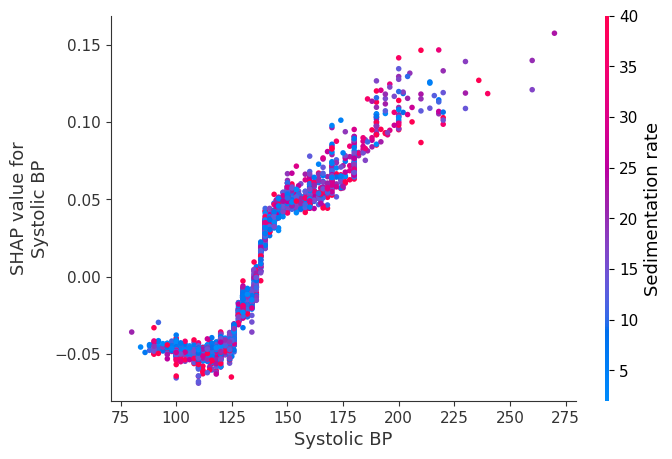

In [187]:
shap.dependence_plot('Systolic BP', shap_values_to_plot, X_test, interaction_index='Sedimentation rate')

- Tekanan darah sistolik tinggi adalah faktor risiko yang signifikan dalam model, terutama ketika mencapai di atas 150 mmHg, dengan peningkatan risiko yang signifikan seiring dengan bertambahnya nilai tekanan darah sistolik.
- Laju endap darah tinggi (warna merah) memperbesar kontribusi risiko pada tekanan darah sistolik yang tinggi, menunjukkan bahwa individu dengan tekanan darah sistolik tinggi dan laju endap darah tinggi berisiko lebih tinggi.
- Laju endap darah rendah (warna biru) pada tekanan darah sistolik rendah menunjukkan risiko yang lebih rendah.

#### Diastolic BP dengan Sex

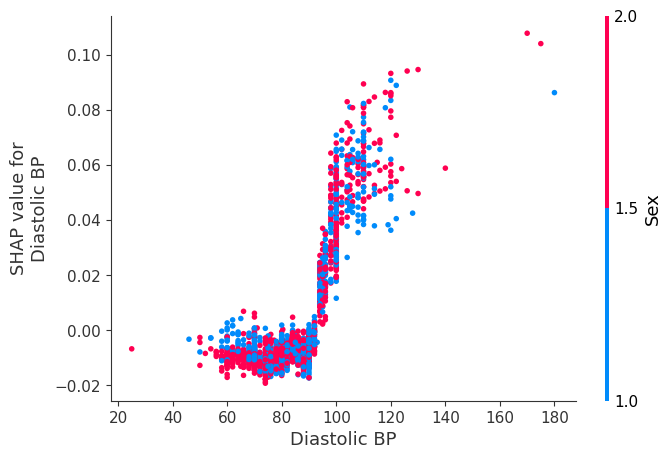

In [188]:
shap.dependence_plot('Diastolic BP', shap_values_to_plot, X_test, interaction_index='Sex')

- Tekanan darah diastolik tinggi adalah faktor risiko yang signifikan dalam model, terutama ketika mencapai di atas 90 mmHg, dengan peningkatan risiko yang signifikan seiring bertambahnya nilai tekanan darah diastolik.
- Jenis kelamin (pria atau wanita) tidak tampak memengaruhi cara tekanan darah diastolik berkontribusi terhadap risiko, karena titik-titik merah dan biru tersebar merata dan tumpang tindih di seluruh grafik.
- Tekanan darah diastolik rendah menunjukkan kontribusi risiko yang lebih rendah, sehingga individu dengan tekanan darah diastolik yang lebih rendah mungkin memiliki risiko kesehatan yang lebih rendah sesuai prediksi model.

#### Systolic BP dengan Sex

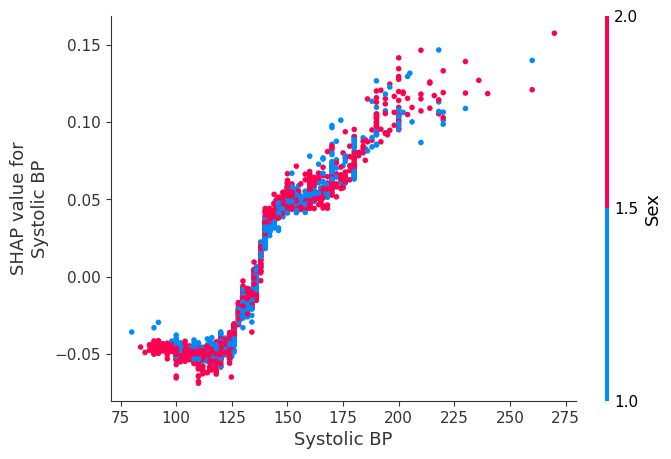

In [189]:
shap.dependence_plot('Systolic BP', shap_values_to_plot, X_test, interaction_index='Sex')

- Tekanan darah sistolik tinggi adalah faktor risiko yang signifikan dalam model ini, terutama ketika mencapai di atas 150 mmHg, dengan peningkatan risiko yang signifikan seiring dengan bertambahnya nilai tekanan darah sistolik.
- Jenis kelamin (pria atau wanita) tidak tampak memengaruhi kontribusi tekanan darah sistolik terhadap risiko secara signifikan, karena titik-titik merah dan biru tersebar merata dan mengikuti pola yang sama.
- Tekanan darah sistolik rendah menunjukkan kontribusi risiko yang lebih rendah, sehingga individu dengan tekanan darah sistolik yang lebih rendah mungkin memiliki risiko kesehatan yang lebih rendah sesuai prediksi model.

#### Serum Albumin dengan Sedimentation Rate

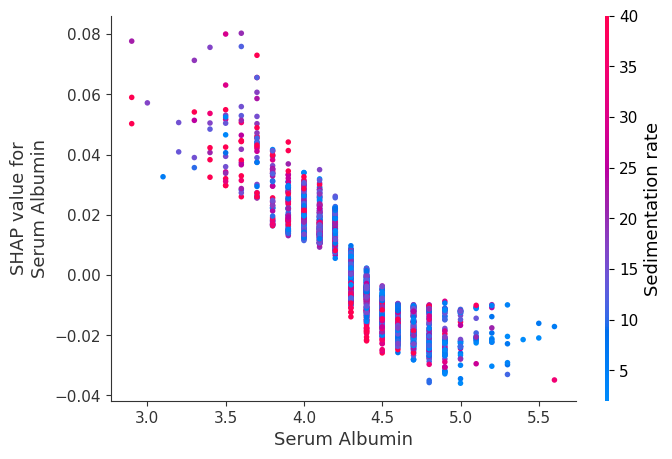

In [190]:
shap.dependence_plot('Serum Albumin', shap_values_to_plot, X_test, interaction_index='Sedimentation rate')

- Kadar serum albumin yang rendah adalah faktor risiko signifikan dalam model, terutama ketika di bawah 3,5 g/dL, di mana risiko meningkat tajam.
- Laju endap darah tinggi (warna merah) memperbesar kontribusi risiko ketika kadar albumin rendah, yang menunjukkan bahwa individu dengan kadar albumin rendah dan laju endap darah tinggi lebih berisiko.
- Kadar serum albumin yang tinggi (di atas 4,0 g/dL) dan laju endap darah rendah (warna biru) dikaitkan dengan risiko yang lebih rendah, menandakan bahwa kondisi kesehatan yang baik biasanya tercermin dalam kadar albumin yang lebih tinggi dan laju endap darah yang rendah.